### Problem Statement:
    Analyze the dataset of individuals and their details related to their credit for whom loan was provided with some terms. Based on our prediction whether the loan will be repayed or not we need to classify the particular loan. If the loan is assigned also assign the repayment terms as business recommendations.

In [3]:
# Importing Required Libraries for Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats.contingency import association
import math
from sklearn.preprocessing import power_transform
from sklearn.feature_selection import mutual_info_classif

In [3]:
# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
## Data Loading and Initial Inspection
"""
Dataset : logistic_regression.csv

"""
df = pd.read_csv('../data/logistic_regression.csv')
print(df.head())

   loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  ...  \
0                Marketing  10+ years           RENT    117000.0  ...   
1          Credit analyst     4 years       MORTGAGE     65000.0  ...   
2             Statistician   < 1 year           RENT     43057.0  ...   
3          Client Advocate    6 years           RENT     54000.0  ...   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0  ...   

  open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
0     16.0     0.0   36369.0       41.8      25.0                    w   
1     17.0

In [5]:
# Basics Information regarding DataFrame COlumns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [6]:
# Basic Statistics of numerical features:
print(df.describe())
print(df.columns)

           loan_amnt       int_rate    installment    annual_inc  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean    14113.888089      13.639400     431.849698  7.420318e+04   
std      8357.441341       4.472157     250.727790  6.163762e+04   
min       500.000000       5.320000      16.080000  0.000000e+00   
25%      8000.000000      10.490000     250.330000  4.500000e+04   
50%     12000.000000      13.330000     375.430000  6.400000e+04   
75%     20000.000000      16.490000     567.300000  9.000000e+04   
max     40000.000000      30.990000    1533.810000  8.706582e+06   

                 dti       open_acc        pub_rec     revol_bal  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean       17.379514      11.311153       0.178191  1.584454e+04   
std        18.019092       5.137649       0.530671  2.059184e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%        11.280000       8.000000       0.000

*   Dataset has 396030 rows with 27 columns (26 features).
*   Dataset consists of different types of features.
*   'loan_amnt', 'int_rate', 'installment','annual_inc','dti','open_acc', 'pub_rec', 'revol_bal','revol_util', 'total_acc','initial_list_status', 'application_type','mort_acc' and  'pub_rec_bankruptcies' seem to be numerical types.
*    Loan amount varies from 500 to 40000 with a standard deviation around 8000
*    Interest rate varies from 5 to 30.
*    dti (Debt to income) and Annual income can be mulipllied to form a new interaction term - debt for analysis
*    Annual income varies from to 0 to 8000000. There seems to be lot of outliers in this column
*  We will first split the data into training and test datasets and visualize different columns and compare with target variable "loan_status" and train and fit Logistic Regression model on training set and use that to predict for test dataset and see how the model has performed.

In [7]:
# Checking for  dupicate rows in DataFrame
df[df.duplicated( keep = 'first')]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address


In [8]:
# Checking for missing values in Dataframe
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

*   The dataset does not have duplicate rows
*   The dataset has missing values in emp_title,emp_length,title,revol_util,mort_acc,pub_rec_bankruptcies.

In [9]:
# As loan_status is the target variable , Checking if there is imbalance in loan_status
loan_status_freq = df['loan_status'].value_counts()
target_imbalance = loan_status_freq['Fully Paid']/loan_status_freq['Charged Off']
print(target_imbalance)

4.098682940017767


In [10]:
loan_data = df.copy() # Creating a copy of training data for EDA.

In [11]:
#  Unique values in each object column
for col in loan_data.columns:
    if loan_data[col].dtype == 'object' and len(loan_data[col].unique())<100:
        print( "Unique values in column ",col,":",list(loan_data[col].unique()))
    elif loan_data[col].dtype == 'object':
        print(col,"has more than 100 unique values, Eg : ",list(loan_data[col].dropna().unique()[:10]))


Unique values in column  term : [' 36 months', ' 60 months']
Unique values in column  grade : ['B', 'A', 'C', 'E', 'D', 'F', 'G']
Unique values in column  sub_grade : ['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4', 'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5', 'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4', 'F2', 'G3']
emp_title has more than 100 unique values, Eg :  ['Marketing', 'Credit analyst ', 'Statistician', 'Client Advocate', 'Destiny Management Inc.', 'HR Specialist', 'Software Development Engineer', 'Office Depot', 'Application Architect', 'Regado Biosciences']
Unique values in column  emp_length : ['10+ years', '4 years', '< 1 year', '6 years', '9 years', '2 years', '3 years', '8 years', '7 years', '5 years', '1 year', nan]
Unique values in column  home_ownership : ['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE', 'ANY']
Unique values in column  verification_status : ['Not Verified', 'Source Verified', 'Verified']
issue_d h

*   Loan term and Employee Length can be converted to numerial variable.
*   Grade and sub grade can be converted to ordinal variables.
*   Employee title, title, address need to be explored further.
*   Variables with few categories like Home Ownership, Verification Status, Initial List Status, Application Type could be one hot encoded.
*   Issue date and Earliest Credit line can be converted to dates and be handled as dates.
*   Loan purpose has a large number of categories. The number of categories can be reduced based on frequency of occurence.

In [12]:
# Checking if address column has unique rows
df[df['address'].duplicated(keep = False )].sort_values(by = 'address').head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
188250,35000.0,60 months,24.89,1025.05,F,F4,BAE Systems,10+ years,MORTGAGE,102800.0,...,9.0,0.0,11560.0,85.0,21.0,f,INDIVIDUAL,6.0,0.0,USCGC Adams\r\nFPO AA 00813
361453,9325.0,36 months,18.49,339.42,D,D2,Marietta Memorial Hospital,10+ years,MORTGAGE,27850.0,...,3.0,0.0,10740.0,82.6,7.0,w,INDIVIDUAL,0.0,0.0,USCGC Adams\r\nFPO AA 00813
277013,10000.0,36 months,11.66,330.53,C,C3,Imagine,1 year,RENT,64000.0,...,10.0,0.0,2388.0,48.7,22.0,f,INDIVIDUAL,NaN,NaN,USCGC Adams\r\nFPO AE 29597
333117,21000.0,36 months,7.90,657.10,A,A4,Experis,10+ years,MORTGAGE,100000.0,...,9.0,0.0,29774.0,51.5,30.0,w,INDIVIDUAL,3.0,0.0,USCGC Adams\r\nFPO AE 29597
203472,18000.0,36 months,14.09,615.99,B,B5,us army,5 years,RENT,72000.0,...,8.0,0.0,17605.0,78.6,17.0,f,INDIVIDUAL,0.0,0.0,USCGC Adams\r\nFPO AE 30723


In [13]:
# There seems to be duplicate values of addresses .Checking first 20 values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(loan_data['address'].head(20))

0        0174 Michelle Gateway\r\nMendozaberg, OK 22690
1     1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2     87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3               823 Reid Ford\r\nDelacruzside, MA 00813
4                679 Luna Roads\r\nGreggshire, VA 11650
5     1726 Cooper Passage Suite 129\r\nNorth Deniseb...
6     1008 Erika Vista Suite 748\r\nEast Stephanie, ...
7                           USCGC Nunez\r\nFPO AE 30723
8                            USCGC Tran\r\nFPO AP 22690
9                3390 Luis Rue\r\nMauricestad, VA 00813
10          40245 Cody Drives\r\nBartlettfort, NM 00813
11    3126 Sean Dale Apt. 141\r\nSouth Matthew, MS 0...
12     4173 David Extension\r\nWest Beckyfort, MS 70466
13           3343 Wells Mews\r\nShellychester, OR 29597
14    0472 Weber Manors Apt. 660\r\nLake Andrew, NH ...
15    11629 Sean Hills Suite 614\r\nStevenfort, HI 3...
16    407 Briggs Lodge Suite 778\r\nWest Aprilboroug...
17    487 Jennifer Parkway Suite 940\r\nCummings

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth',None):
    print(loan_data['address'].head(20).apply(lambda x: x.split('\r')))

0                  [0174 Michelle Gateway, \nMendozaberg, OK 22690]
1               [1076 Carney Fort Apt. 347, \nLoganmouth, SD 05113]
2               [87025 Mark Dale Apt. 269, \nNew Sabrina, WV 05113]
3                         [823 Reid Ford, \nDelacruzside, MA 00813]
4                          [679 Luna Roads, \nGreggshire, VA 11650]
5     [1726 Cooper Passage Suite 129, \nNorth Deniseberg, DE 30723]
6          [1008 Erika Vista Suite 748, \nEast Stephanie, TX 22690]
7                                     [USCGC Nunez, \nFPO AE 30723]
8                                      [USCGC Tran, \nFPO AP 22690]
9                          [3390 Luis Rue, \nMauricestad, VA 00813]
10                    [40245 Cody Drives, \nBartlettfort, NM 00813]
11             [3126 Sean Dale Apt. 141, \nSouth Matthew, MS 00813]
12               [4173 David Extension, \nWest Beckyfort, MS 70466]
13                     [3343 Wells Mews, \nShellychester, OR 29597]
14            [0472 Weber Manors Apt. 660, \nLak

In [15]:
zipcodes = loan_data['address'].apply(lambda x : x.split()[-1]) # Taking last term in address
print(zipcodes.unique())

['22690' '05113' '00813' '11650' '30723' '70466' '29597' '48052' '86630'
 '93700']


The last term in address seems to be the zipcodes

In [16]:
states = loan_data['address'].apply(lambda x : x.split()[-2]) # Taking last but one term in address
print(states.unique())

['OK' 'SD' 'WV' 'MA' 'VA' 'DE' 'TX' 'AE' 'AP' 'NM' 'MS' 'OR' 'NH' 'HI'
 'PA' 'CO' 'AL' 'FL' 'AZ' 'WI' 'NC' 'IN' 'MO' 'AA' 'TN' 'KS' 'ND' 'CT'
 'WY' 'NE' 'RI' 'AR' 'MI' 'IL' 'LA' 'NY' 'IA' 'AK' 'UT' 'MD' 'WA' 'MN'
 'OH' 'MT' 'NJ' 'DC' 'NV' 'VT' 'CA' 'ME' 'ID' 'GA' 'KY' 'SC']


The last but one term in Address seems to be a common state like terms

In [17]:
for i in loan_data['address'].iloc[:10]:
    print(i.split('\n')[-1][:-8].strip(", "))

Mendozaberg
Loganmouth
New Sabrina
Delacruzside
Greggshire
North Deniseberg
East Stephanie
FPO
FPO
Mauricestad


In [18]:
towns = pd.DataFrame(loan_data['address'].apply(lambda x : x.split('\n')[-1][:-8].strip(", "))) # Taking the 3rd term from last in address
towns_frequency = towns['address'].value_counts().sort_values(ascending = False)
print(towns_frequency.head(30))

address
DPO                 14289
APO                 14060
FPO                 14035
East Michael          311
Port Michael          305
Lake Michael          290
New Michael           287
North Michael         284
West Michael          284
South Michael         279
New James             218
North David           217
Lake John             216
East James            213
West James            209
Lake David            205
Port Jennifer         202
Lake Christopher      201
New David             200
Port John             199
Michaelmouth          198
West Christopher      195
West David            194
West Jennifer         192
West Robert           191
Smithmouth            191
East David            190
South James           188
North John            187
Port David            186
Name: count, dtype: int64


It seems most the values are names and are randomly assigned. We can use DPO, APO, FPO and take the rest as others and apply One Hot Encoding for the towns column

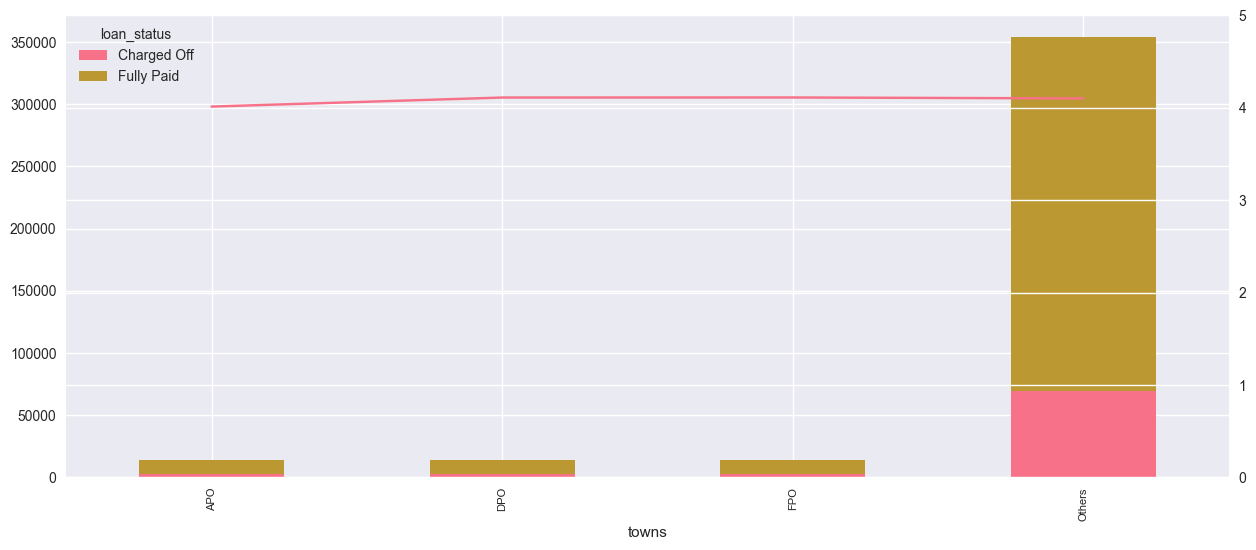

In [19]:
# Plotting town freequency along with target.
town_status = pd.DataFrame(towns).rename(columns={'address':'towns'})#.reset_index(names = 'id')
town_status['towns'] = town_status['towns'].apply(lambda x:  x if x in ['DPO','APO','FPO'] else 'Others')
town_status['loan_status'] = loan_data['loan_status']
town_status = town_status.reset_index(names = 'id').pivot_table(values = 'id',index='towns' , columns = 'loan_status',aggfunc='count')

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(fontsize=8)
town_status.plot(kind = 'bar',stacked = True ,ax=ax  )
ax2 = ax.twinx()
ax2.plot(town_status['Fully Paid']/town_status['Charged Off'])
ax2.set_yticks([0,1,2,3,4,5])

There's no pattern between town name and loan status

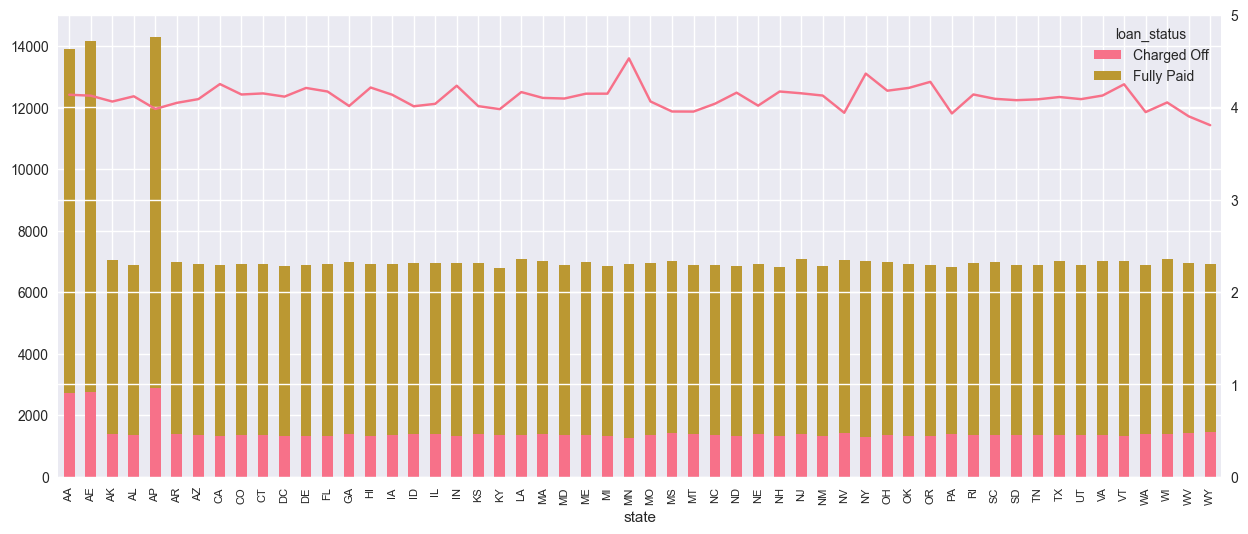

In [ ]:
# Plotting state freequency along with target.
state_status = pd.DataFrame(states).rename(columns={'address':'state'})#.reset_index(names = 'id')
state_status['loan_status'] = loan_data['loan_status']
state_status = state_status.reset_index(names = 'id').pivot_table(values = 'id',index='state' , columns = 'loan_status',aggfunc='count')

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(fontsize=8)
state_status.plot(kind = 'bar',stacked = True ,ax=ax  )
ax2 = ax.twinx()
ax2.plot(state_status['Fully Paid']/state_status['Charged Off'])
ax2.set_yticks([0,1,2,3,4,5])

Insights about state column
*  There is little variation in the state column among the 54 states and lot of categories involved, we can exclude this feature for prediction for now.

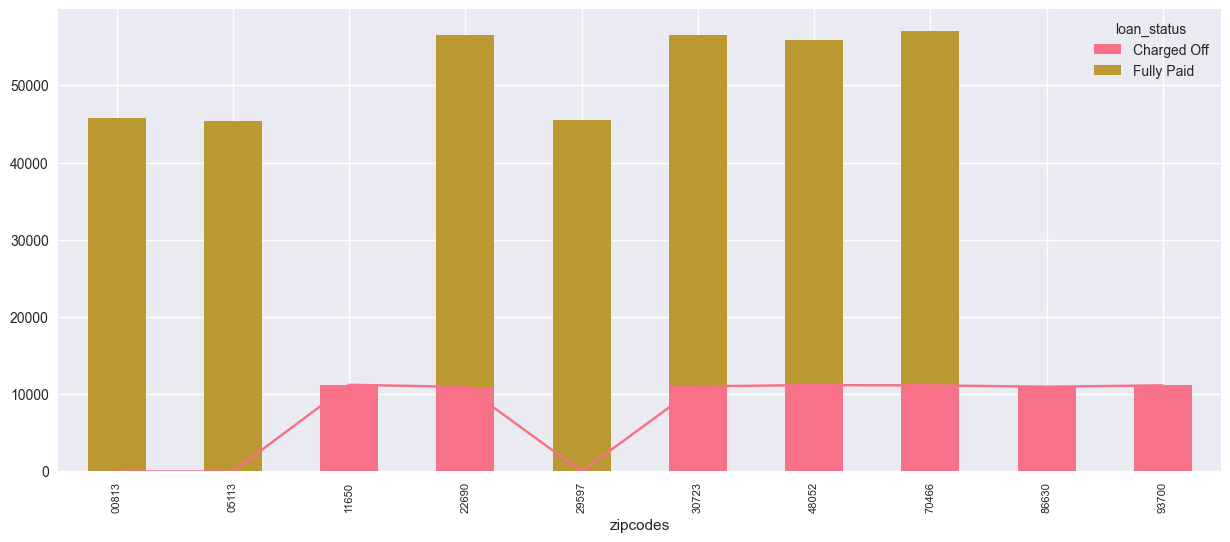

In [28]:
# Plotting zipcodes freequency along with target.
zipcodes_status = pd.DataFrame(zipcodes).rename(columns={'address':'zipcodes'})#.reset_index(names = 'id')
zipcodes_status['loan_status'] = loan_data['loan_status']
zipcodes_status = zipcodes_status.reset_index(names = 'id').pivot_table(values = 'id',index='zipcodes' , columns = 'loan_status',aggfunc='count',fill_value=0)

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(fontsize=8)
zipcodes_status.plot(kind = 'bar',stacked = True ,ax=ax  )
r_p = ax.plot((zipcodes_status['Charged Off']))


In [29]:
zipcodes_status

loan_status,Charged Off,Fully Paid
zipcodes,,
00813,0,45824
05113,0,45402
11650,11226,0
22690,10954,45573
29597,0,45471
30723,11021,45525
48052,11192,44725
70466,11148,45837
86630,10981,0


Insights about zipcodes column
*   3 zipcodes have all defaulted loans and 3 zipcodes have all fully paid loans. The rest have default rate of 25%
*   zipcodes seems to be a valuable feature as the target ratio for different zipcodess are in extremes.
*   One Hot encoding can be applied to this column as it has lesser number categories (10) , to get maximum information from this column

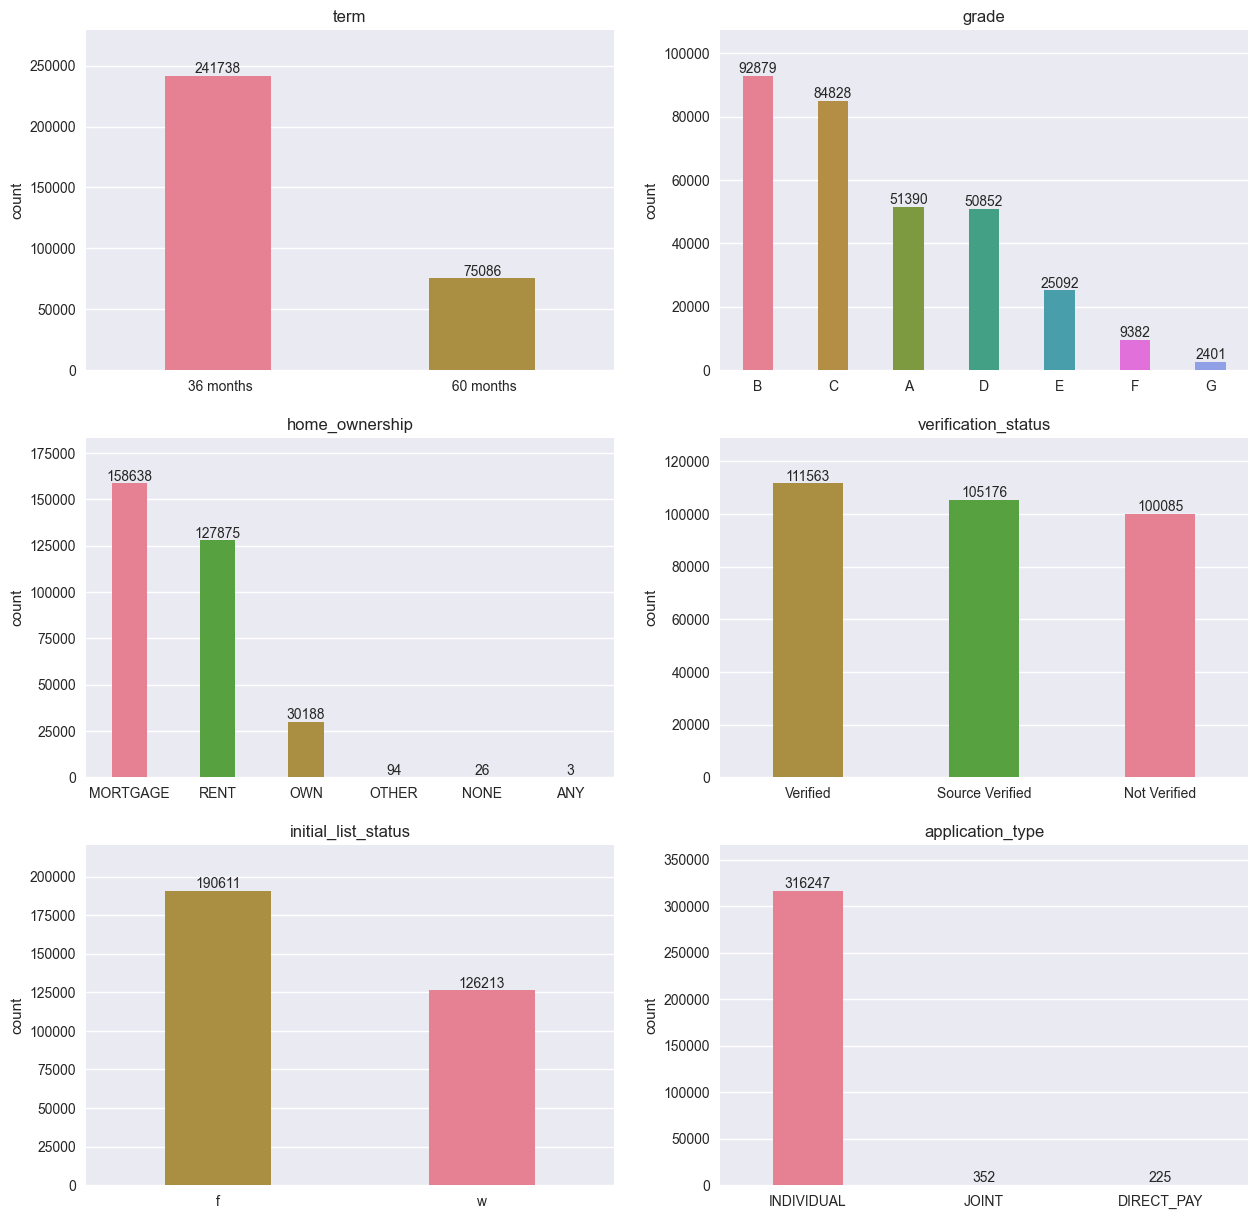

In [19]:
# Count plots for categorical columns Loan term, Loan Grade, Home Ownership, Verification Status, Loan Status, Initial List Status, Application Type
cate_columns = ['term','grade','home_ownership','verification_status','initial_list_status','application_type']
r = 0
fig, ax =plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    for j in range(2):
        sns.countplot(x = loan_data[cate_columns[r]].rename(''),order = loan_data[cate_columns[r]].value_counts(ascending=False).index,hue = loan_data[cate_columns[r]],ax = ax[i][j],orient = 'v',width = 0.4, ).set_title(cate_columns[r])
        bottom,top = ax[i][j].get_ylim()
        ax[i][j].set_ylim(top = top*1.1)
        abs_values = loan_data[cate_columns[r]].value_counts(sort = False).values
        for p,q in zip(ax[i][j].containers,abs_values):
            ax[i][j].bar_label(container= p, labels=[q])
        r+=1
        if r==6:
            break

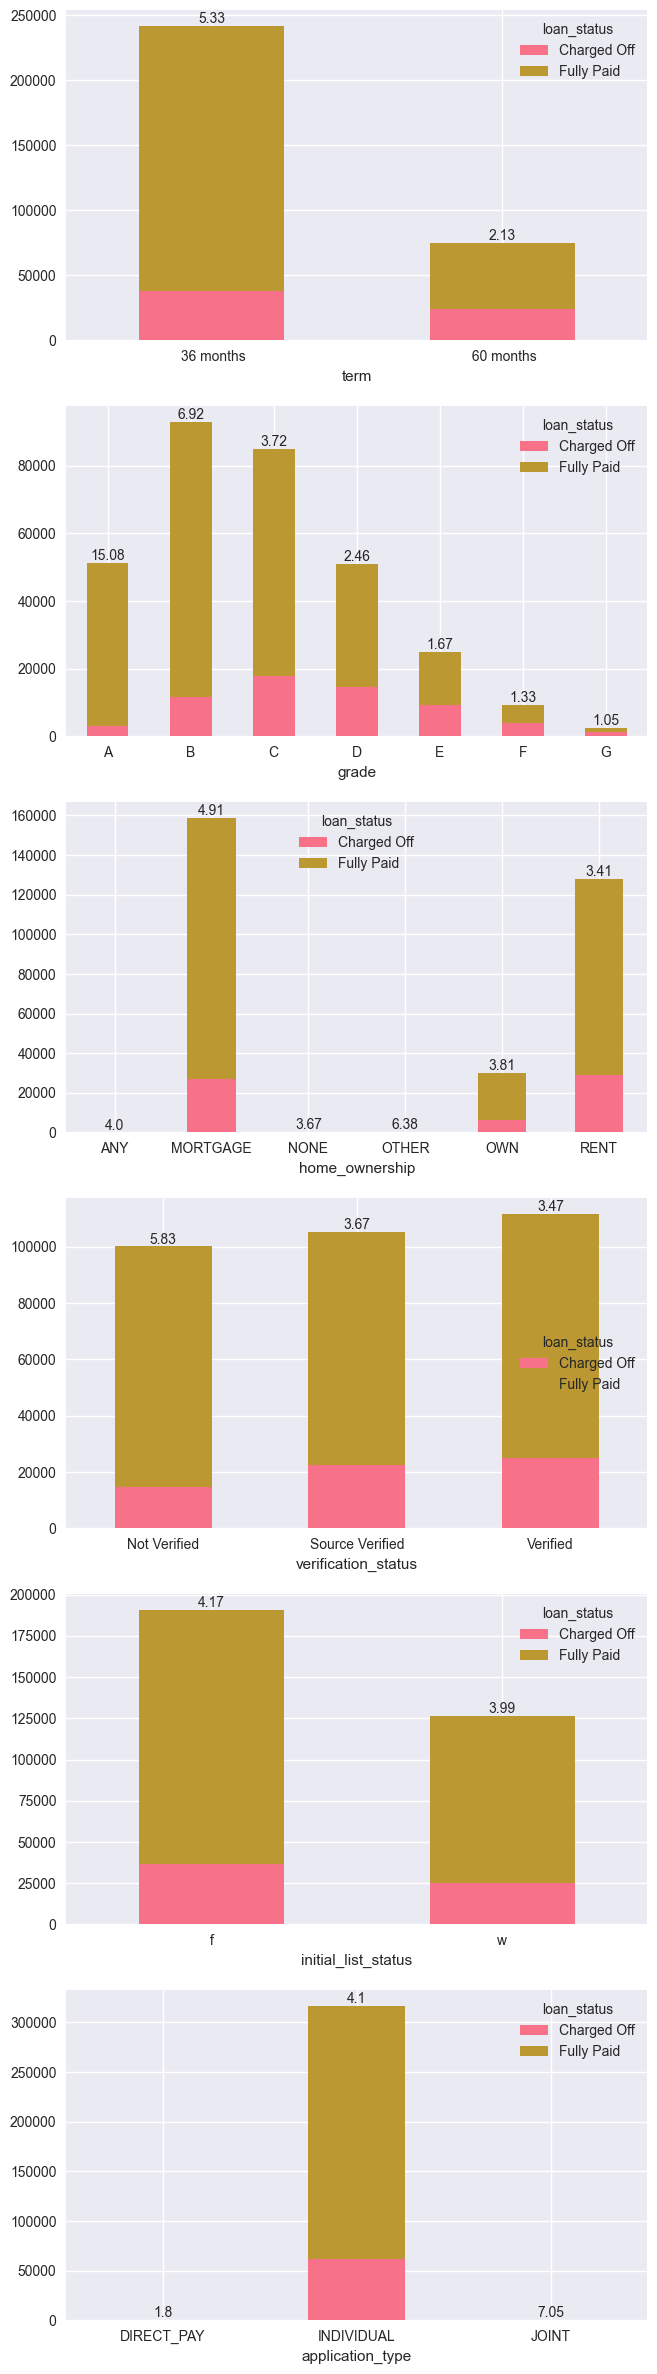

In [20]:
# Plotting target distribution with different categories in loan term, grade, home ownership, verification status, initial list status, application type
cate_columns = ['term','grade','home_ownership','verification_status','initial_list_status','application_type']
fig,ax = plt.subplots(len(cate_columns),1)
fig.set_figheight(30)
fig.set_figwidth(7.5)
for i in range(len(cate_columns)):
    pd.crosstab(loan_data[cate_columns[i]],y_train).plot(kind='bar', stacked=True,ax= ax[i],fontsize=10)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 0)
    (bottom,top) = ax[i].containers
    (bottom_labels,top_labels) = (bottom.datavalues,top.datavalues)
    ratios = [np.round((top_labels[i]+1)/(bottom_labels[i]+1),2) for i in range(len(top))]
    ax[i].bar_label(top,labels = ratios,label_type = 'edge')

In [21]:
# categories in term column
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [22]:
# Applying encoding on target y
y_encoder = LabelEncoder( )
y_train_encoded = y_encoder.fit_transform(y_train)
y_encoder.classes_

array(['Charged Off', 'Fully Paid'], dtype=object)

In [23]:
# converting Loan term to numerical feature and finding correlation with target:
loan_term = pd.DataFrame(loan_data['term'].apply(lambda x: int(x[1:3])))
loan_term['loan_status'] = y_train_encoded
loan_term.corr().loc['term','loan_status']

np.float64(-0.17288544970139827)

Loan term insights
*    The data set is more biased towards loan term of 36 months
*    36 months has a fully paid to charged off ratio of 5 compared with 2 for 60 months.
*    Loan term when used as a number has very less correlation with target variable.
*    We can try one hot encoding and as a numerical feature for our prediction

Grade column insights
*    The data set is unequally distributed across A through G.
*    Fully paid to cherged off ratio increases with higher grade.
*    We can try ordinal encoding with different ordinal scales for our prediction

Home Ownership column insights
*   Majority of the values are in Mortgage, Rent or Own.
*   We can combine rest as 'Others'.
*   The target ratios (Mortgage: 4.9, Own: 3.8, Rent: 3.4) are significant here and one hot encoding can be applied as there are only 5 categories including 'Others'

Verification Status column insights
*  The data is almost equally distributed between Verified, Not Verified and Source Verified.
*  The target ratios (Not Verified: 5.8, Source Verfied: 3.67, Verfied: 3.47) are significant here and one hot encoding can be applied as there are only 3 categories.

Initial List Status column insights
*  The data is slightly biased towards f category.
*  The target ratios are slightly different and one hot encoding can be used here as there are only two categories

Application Type column Status
*  The application type column has one major category Individual and the rest of the categories constitute a very small percentage.
*  This column can be dropped as the majority rows have the same category and do not add any significant information for prediction.

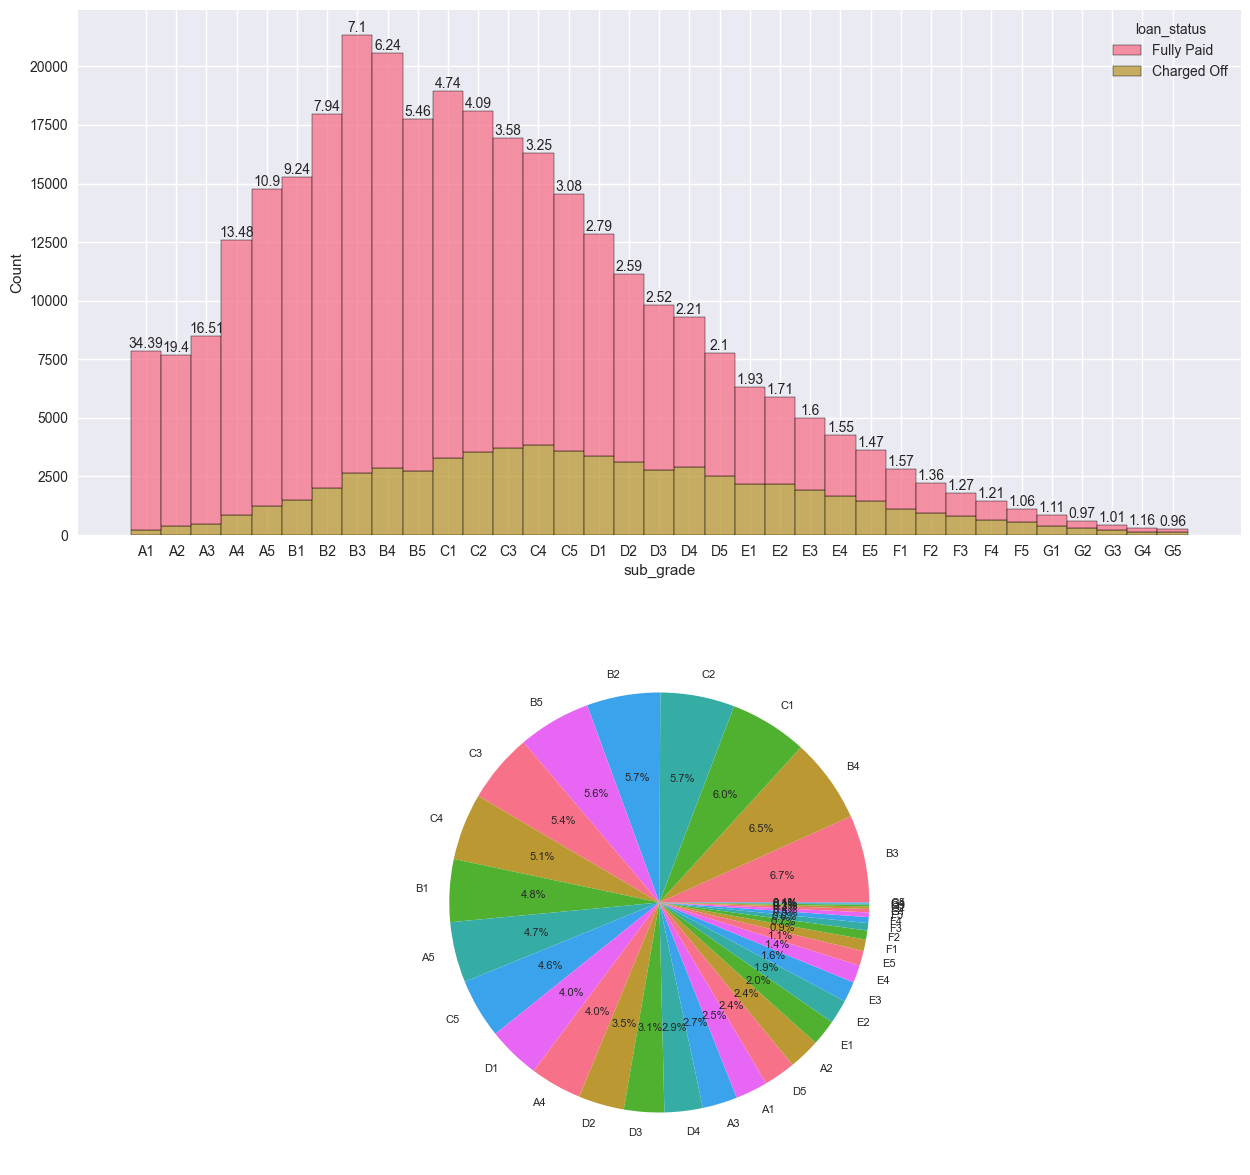

In [24]:
# Sub grade feature viz
fig,ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(15)

sub_grade_sorted =pd.DataFrame(loan_data['sub_grade'])
sub_grade_sorted['loan_status'] = y_train
sub_grade_sorted = sub_grade_sorted.sort_values(by = 'sub_grade')
# Histogram with stacked plot for subgrade with target vales
sns.histplot(sub_grade_sorted,ax = ax[0],multiple='stack',stat = 'count', x = 'sub_grade',element='bars',legend = True,hue = 'loan_status')
# Making labels for loan_status ratio.
labels = [np.round(i[1]/i[0],2) for i in zip(ax[0].containers[0].datavalues,ax[0].containers[1].datavalues)]

rects = ax[0].containers[1].patches
rects2 = ax[0].containers[0].patches
for rect,rect2, label in zip(rects,rects2, labels):
     height = rect.get_height()
     height2 = rect2.get_height()
     ax[0].text(
         rect.get_x() + rect.get_width() / 2, height+height2, label, ha="center", va="bottom"
     )
ax[1].pie( sub_grade_sorted['sub_grade'].value_counts(), labels = list(sub_grade_sorted['sub_grade'].value_counts().keys()),autopct='%1.1f%%',textprops={'fontsize': 8})
plt.show()

Sub grade column insights
*   Sub grade is distributed unevenly across all subgrades with most subgrades between A4 to D4.
*   Fully paid to cherged off ratio increases with higher grade.
*    We can try ordinal encoding with different ordinal scales for our prediction
*  There might be collinearity with grade column after encoding that needs to be checked.

In [25]:
# Categories in Employee Length
loan_data['emp_length'].unique()

array(['< 1 year', '6 years', '8 years', '5 years', nan, '3 years',
       '9 years', '10+ years', '1 year', '2 years', '4 years', '7 years'],
      dtype=object)

In [26]:
# Displaying rows where Employee length is missing, and percentage employee length missing in dataset
print(loan_data[loan_data['emp_length'].isna()].head())
print("Percentage missing in Employee length:", loan_data['emp_length'].isnull().sum() * 100 / loan_data.shape[0])

        loan_amnt        term  int_rate  installment grade sub_grade  \
123791     7000.0   36 months     13.11       236.23     B        B4   
183393     9600.0   36 months     10.15       310.45     B        B2   
97304     10000.0   60 months     15.31       239.53     C        C4   
110103     9000.0   36 months     23.40       350.27     E        E5   
202500    10000.0   36 months     10.99       327.34     B        B2   

       emp_title emp_length home_ownership  annual_inc verification_status  \
123791       NaN        NaN           RENT     24560.0            Verified   
183393       NaN        NaN           RENT     85000.0            Verified   
97304        NaN        NaN            OWN     50000.0     Source Verified   
110103       NaN        NaN       MORTGAGE     55000.0            Verified   
202500       NaN        NaN       MORTGAGE     53000.0            Verified   

         issue_d             purpose               title    dti  \
123791  Jun-2013         credit

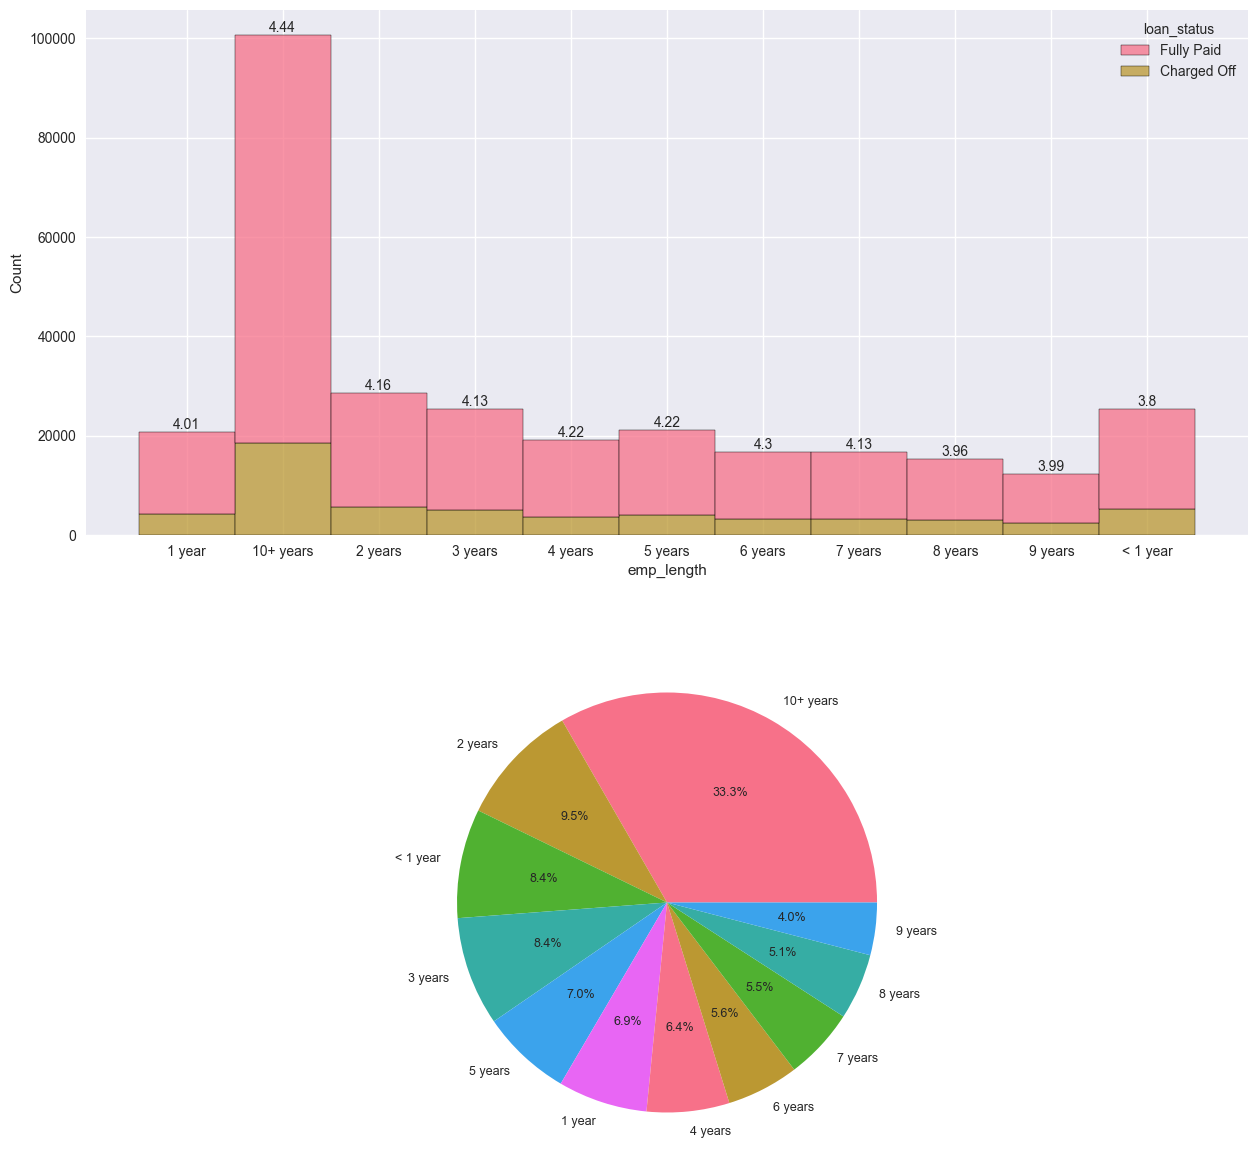

In [27]:
# Visualizing Employee Length distibution

emp_length_num = pd.DataFrame(loan_data['emp_length'])
emp_length_num['loan_status'] = y_train
emp_length_num = emp_length_num.sort_values('emp_length')
fig,ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(15)

# Histogram with stacked plot for employment length with target vales
sns.histplot(emp_length_num,ax = ax[0],multiple='stack',stat = 'count', x = 'emp_length',element='bars',legend = True,hue = 'loan_status')
# Making labels for loan_status ratio.
labels = [np.round(i[1]/i[0],2) for i in zip(ax[0].containers[0].datavalues,ax[0].containers[1].datavalues)]

rects = ax[0].containers[1].patches
rects2 = ax[0].containers[0].patches
for rect,rect2, label in zip(rects,rects2, labels):
     height = rect.get_height()
     height2 = rect2.get_height()
     ax[0].text(
         rect.get_x() + rect.get_width() / 2, height+height2, label, ha="center", va="bottom"
     )
ax[1].pie( emp_length_num['emp_length'].value_counts(), labels = list(emp_length_num['emp_length'].value_counts().keys()),autopct='%1.1f%%',textprops={'fontsize': 9})
plt.show()


Employment Length column insights
*  The dataset is split across different employment lengths.
*  10+ years has the largest count.
*  The missing data in column dont seem to follow a pattern and can be imputed using median of the column
*  The categories can be converted to numerical values from 0 to 10.
*  '<1 years' can be considered as 0, '10+ years' can be considered as 10.

In [28]:
# Converting the column to numerical , to calculate median, and calculating correlation with target
def empl_length(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0.5
    else:
        return int(x[0])
emp_length_num = pd.DataFrame(loan_data['emp_length'].apply(empl_length))
emp_length_num['loan_status'] = y_train_encoded
print('Median for Employment Length:',emp_length_num['emp_length'].median())
print('Correlation with target variable after conversion:',emp_length_num.corr().loc['emp_length','loan_status'])

Median for Employment Length: 6.0
Correlation with target variable after conversion: 0.014128434164948767


In [29]:
# Employee Title Distribution
emp_titles = pd.DataFrame(loan_data['emp_title'])
emp_titles['loan_status'] = y_train_encoded
# No of rows for each category
emp_titles_freq= pd.DataFrame(emp_titles.groupby('emp_title')['loan_status'].mean())
emp_titles_freq['count'] = loan_data['emp_title'].value_counts()

emp_titles_freq = emp_titles_freq.sort_values(by = 'count')
print("Least occuring 5 categories",emp_titles_freq.head(5))
print("Most occuring 5 categories",emp_titles_freq.iloc[-5:])
print("Unique categories:",emp_titles_freq.shape[0])

Least occuring 5 categories                                   loan_status  count
emp_title                                           
​License Compliance Investigator          1.0      1
zilkha residence                          0.0      1
zion lutheran school                      1.0      1
zion pre k                                1.0      1
zip local                                 1.0      1
Most occuring 5 categories                   loan_status  count
emp_title                           
Registered Nurse     0.794258   1463
Supervisor           0.780205   1465
RN                   0.801900   1474
Manager              0.786049   3412
Teacher              0.806296   3526
Unique categories: 143553


In [30]:
# As there are a lot of unique categories, comparing association of employee title column with target for different number of categories considered for employee title
for i in range(3,16):
    sig_emp_titles =  list(emp_titles_freq[emp_titles_freq['count']>=(i*100)].index)  # Here (i*100) will be the threshold for minimum number of rows allowed for a category

    sig_emp_data = loan_data['emp_title'].apply(lambda x : x if x in sig_emp_titles else 'Others')
    emp_title_encoder = LabelEncoder()
    emp_titles_encoded = emp_title_encoder.fit_transform(sig_emp_data)
    print("Association between employee title when",100*i,"is considered as threshold:",association(np.array([emp_titles_encoded+1,y_train_encoded+1]).T,method='cramer'))

Association between employee title when 300 is considered as threshold: 0.08684059169526927
Association between employee title when 400 is considered as threshold: 0.09949075976066463
Association between employee title when 500 is considered as threshold: 0.09962569239752402
Association between employee title when 600 is considered as threshold: 0.1070790072539799
Association between employee title when 700 is considered as threshold: 0.11617661632915163
Association between employee title when 800 is considered as threshold: 0.11460933303247615
Association between employee title when 900 is considered as threshold: 0.1416840835659627
Association between employee title when 1000 is considered as threshold: 0.1550947034708459
Association between employee title when 1100 is considered as threshold: 0.18972716150946972
Association between employee title when 1200 is considered as threshold: 0.17584553061714975
Association between employee title when 1300 is considered as threshold: 0.16271

Employee Title column Insights
*  There are large number of categories in Employee Title column with each category count ranging from 1 to 3526
*   As categories with very less number of rows they are not significant statistically, so we have to find number of categories of employee title to consider for predicting target
*   Calculating Association using Cramer's V of Employee Title feature with target for different number of categories considered taking the minimum count per catgeory as the variable.
*  We find that minimum count of category at 1100 which corresponds to top 10 categories in employee title by number of rows gives the best association with Target variable and will be considered. Rest of the rows including missing values can be considered as "Others".

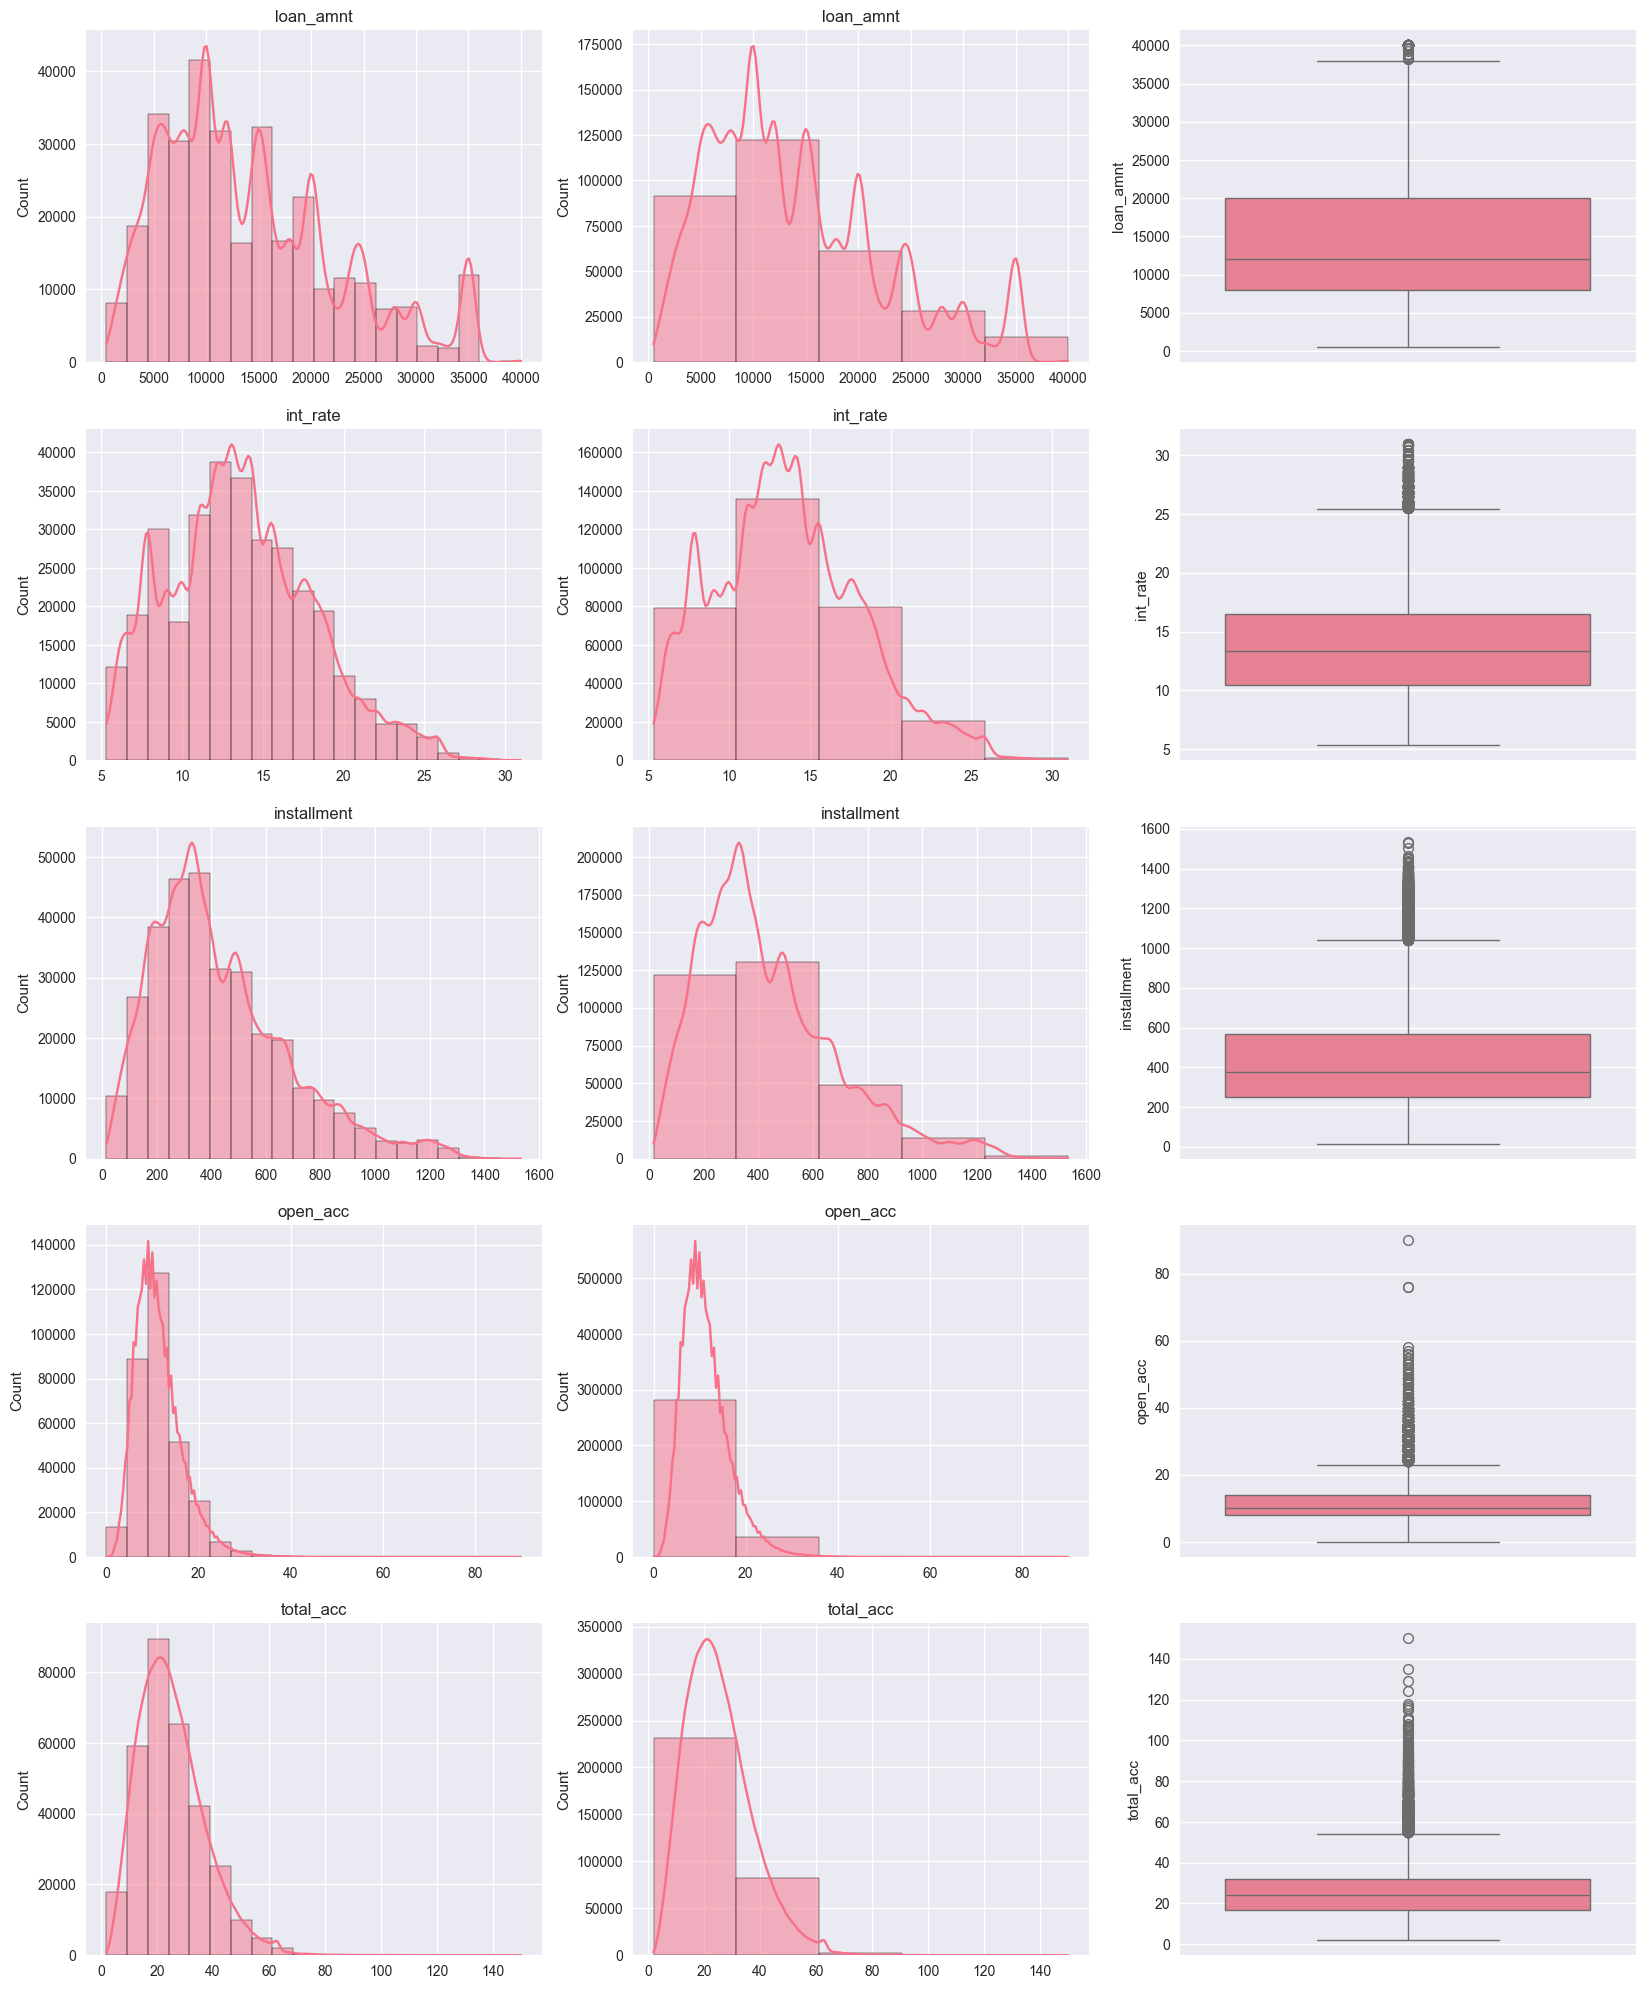

In [31]:
# Box Plot and Distplots for numerical features  "loan_amnt","int_rate","installment","open_acc","total_acc"
num_columns = ["loan_amnt","int_rate","installment","open_acc","total_acc"]
fig, ax =plt.subplots(5,3)
fig.set_figheight(25)
fig.set_figwidth(20)
for col in range(len(num_columns)):
    sns.histplot(loan_data[num_columns[col]].rename(''),ax = ax[col][0],kde = True,bins = 20)
    sns.histplot(loan_data[num_columns[col]].rename(''),ax = ax[col][1],kde = True,bins = 5)
    sns.boxplot(loan_data[num_columns[col]], ax = ax[col][2])
    ax[col][0].set_title(num_columns[col])
    ax[col][1].set_title(num_columns[col])

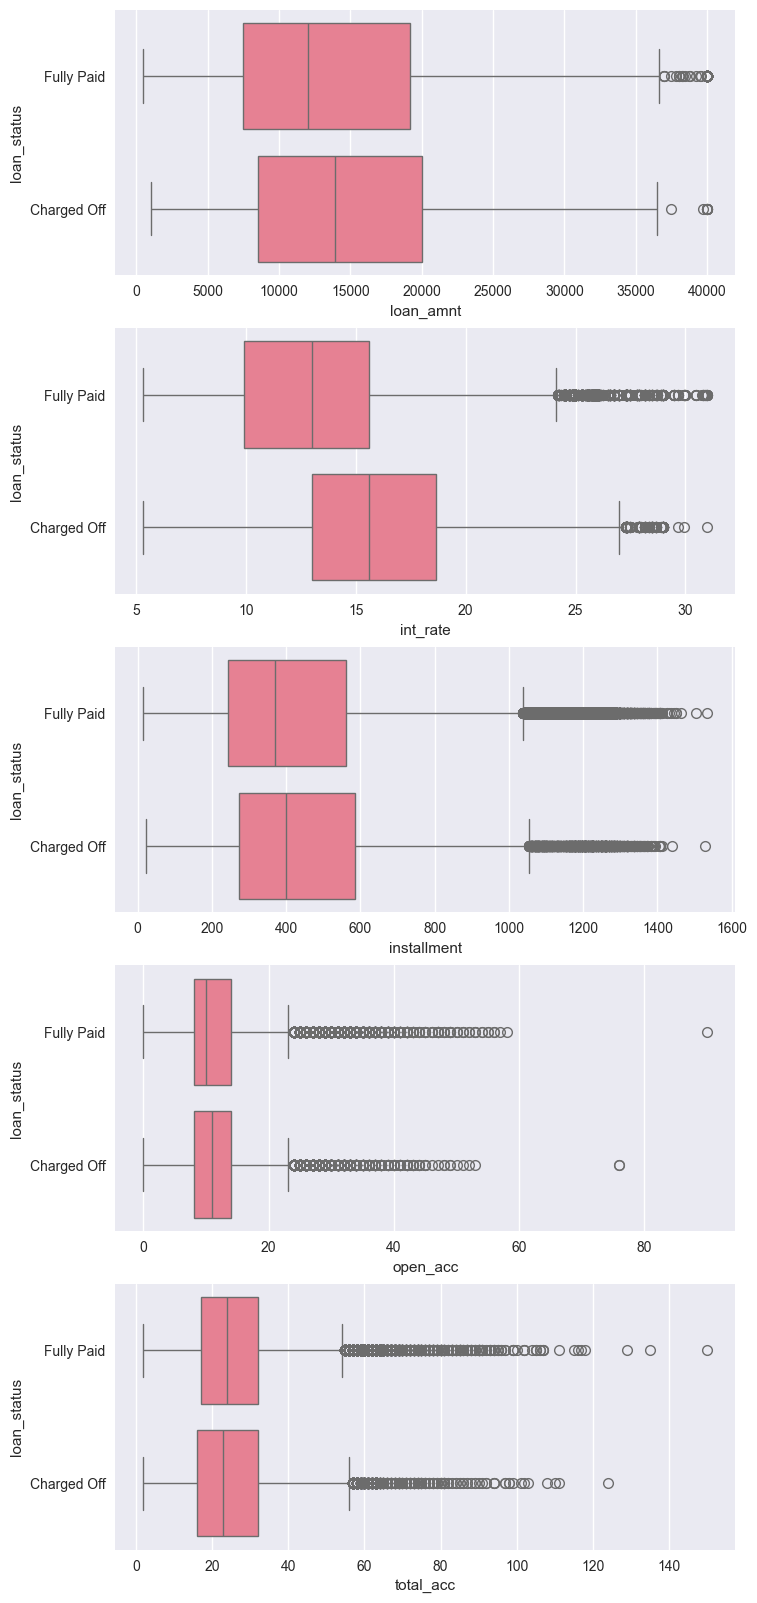

In [32]:
# Numerical Features vs Target Variable (Loan_status)
num_var = ["loan_amnt","int_rate","installment","open_acc","total_acc"]
fig,ax = plt.subplots(5,1)
fig.set_figheight(20)
for i in range(5):
    sns.boxplot(loan_data,x = num_var[i],y= y_train,ax=ax[i])

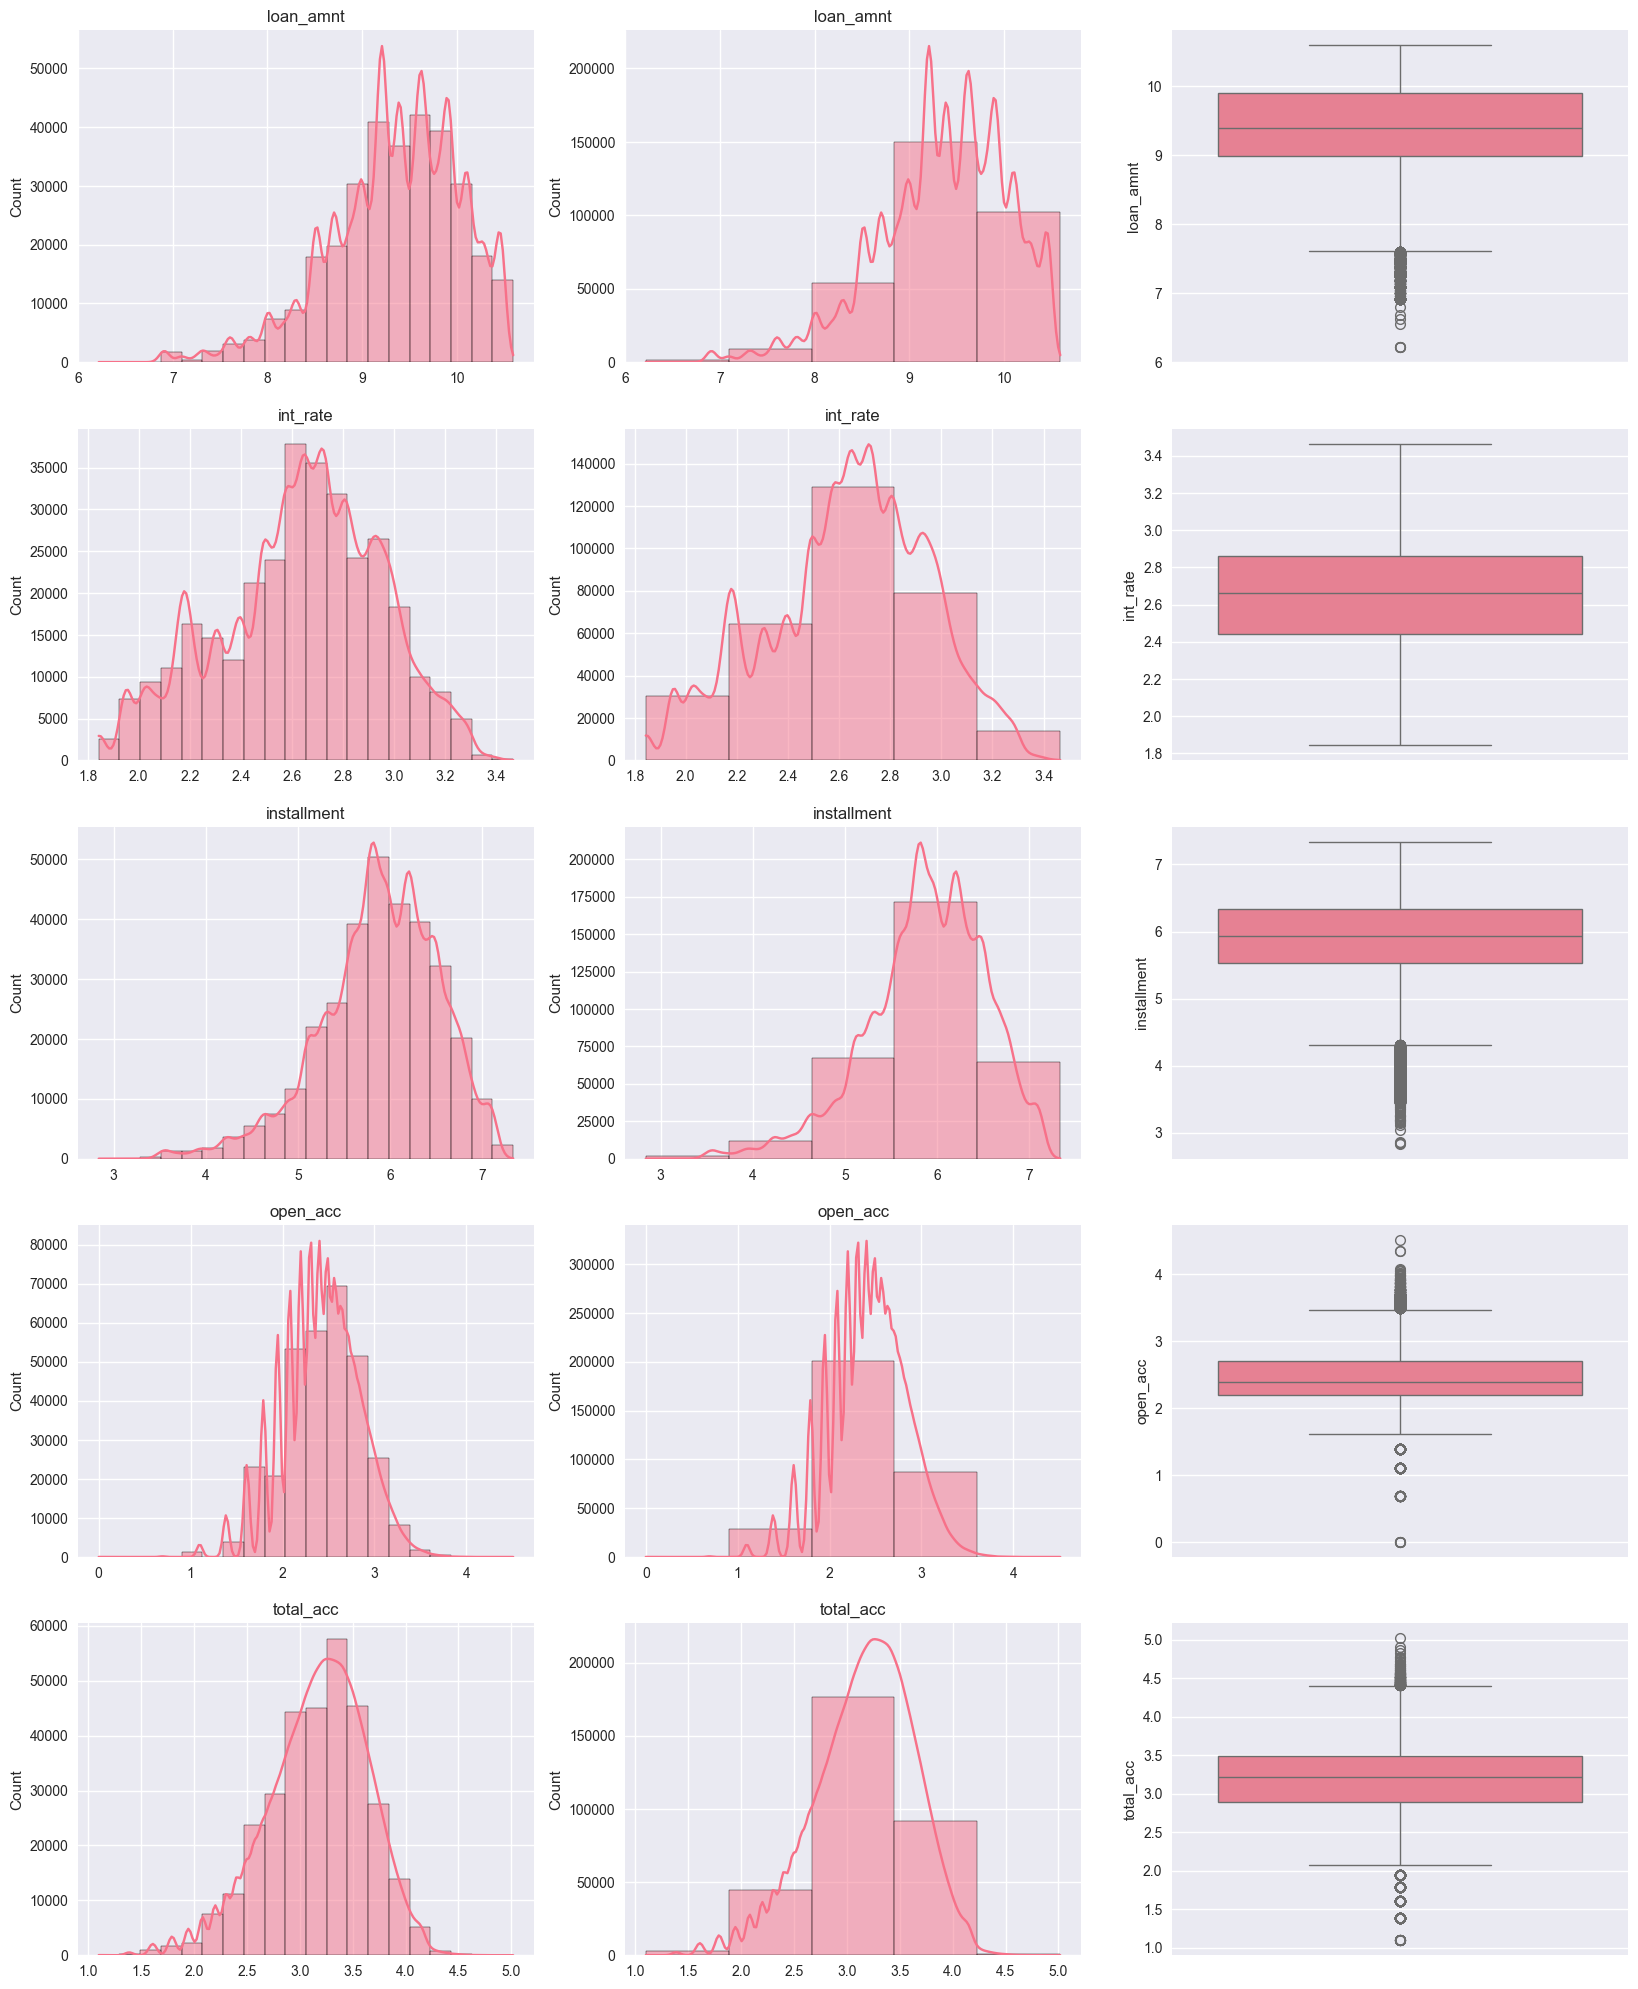

In [33]:
# As there seems to be a large amount of outliers, applying log transformation and visualizing the column
# Box Plot and Distplots for numerical features  "loan_amnt","int_rate","installment","open_acc","total_acc"
num_columns = ["loan_amnt","int_rate","installment","open_acc","total_acc"]
fig, ax =plt.subplots(5,3)
fig.set_figheight(25)
fig.set_figwidth(20)
for col in range(len(num_columns)):
    sns.histplot(loan_data[num_columns[col]].apply(lambda x: math.log(x+1)).rename(''),ax = ax[col][0],kde = True,bins = 20)
    sns.histplot(loan_data[num_columns[col]].apply(lambda x: math.log(x+1)).rename(''),ax = ax[col][1],kde = True,bins = 5)
    sns.boxplot(loan_data[num_columns[col]].apply(lambda x: math.log(x+1)), ax = ax[col][2])
    ax[col][0].set_title(num_columns[col])
    ax[col][1].set_title(num_columns[col])

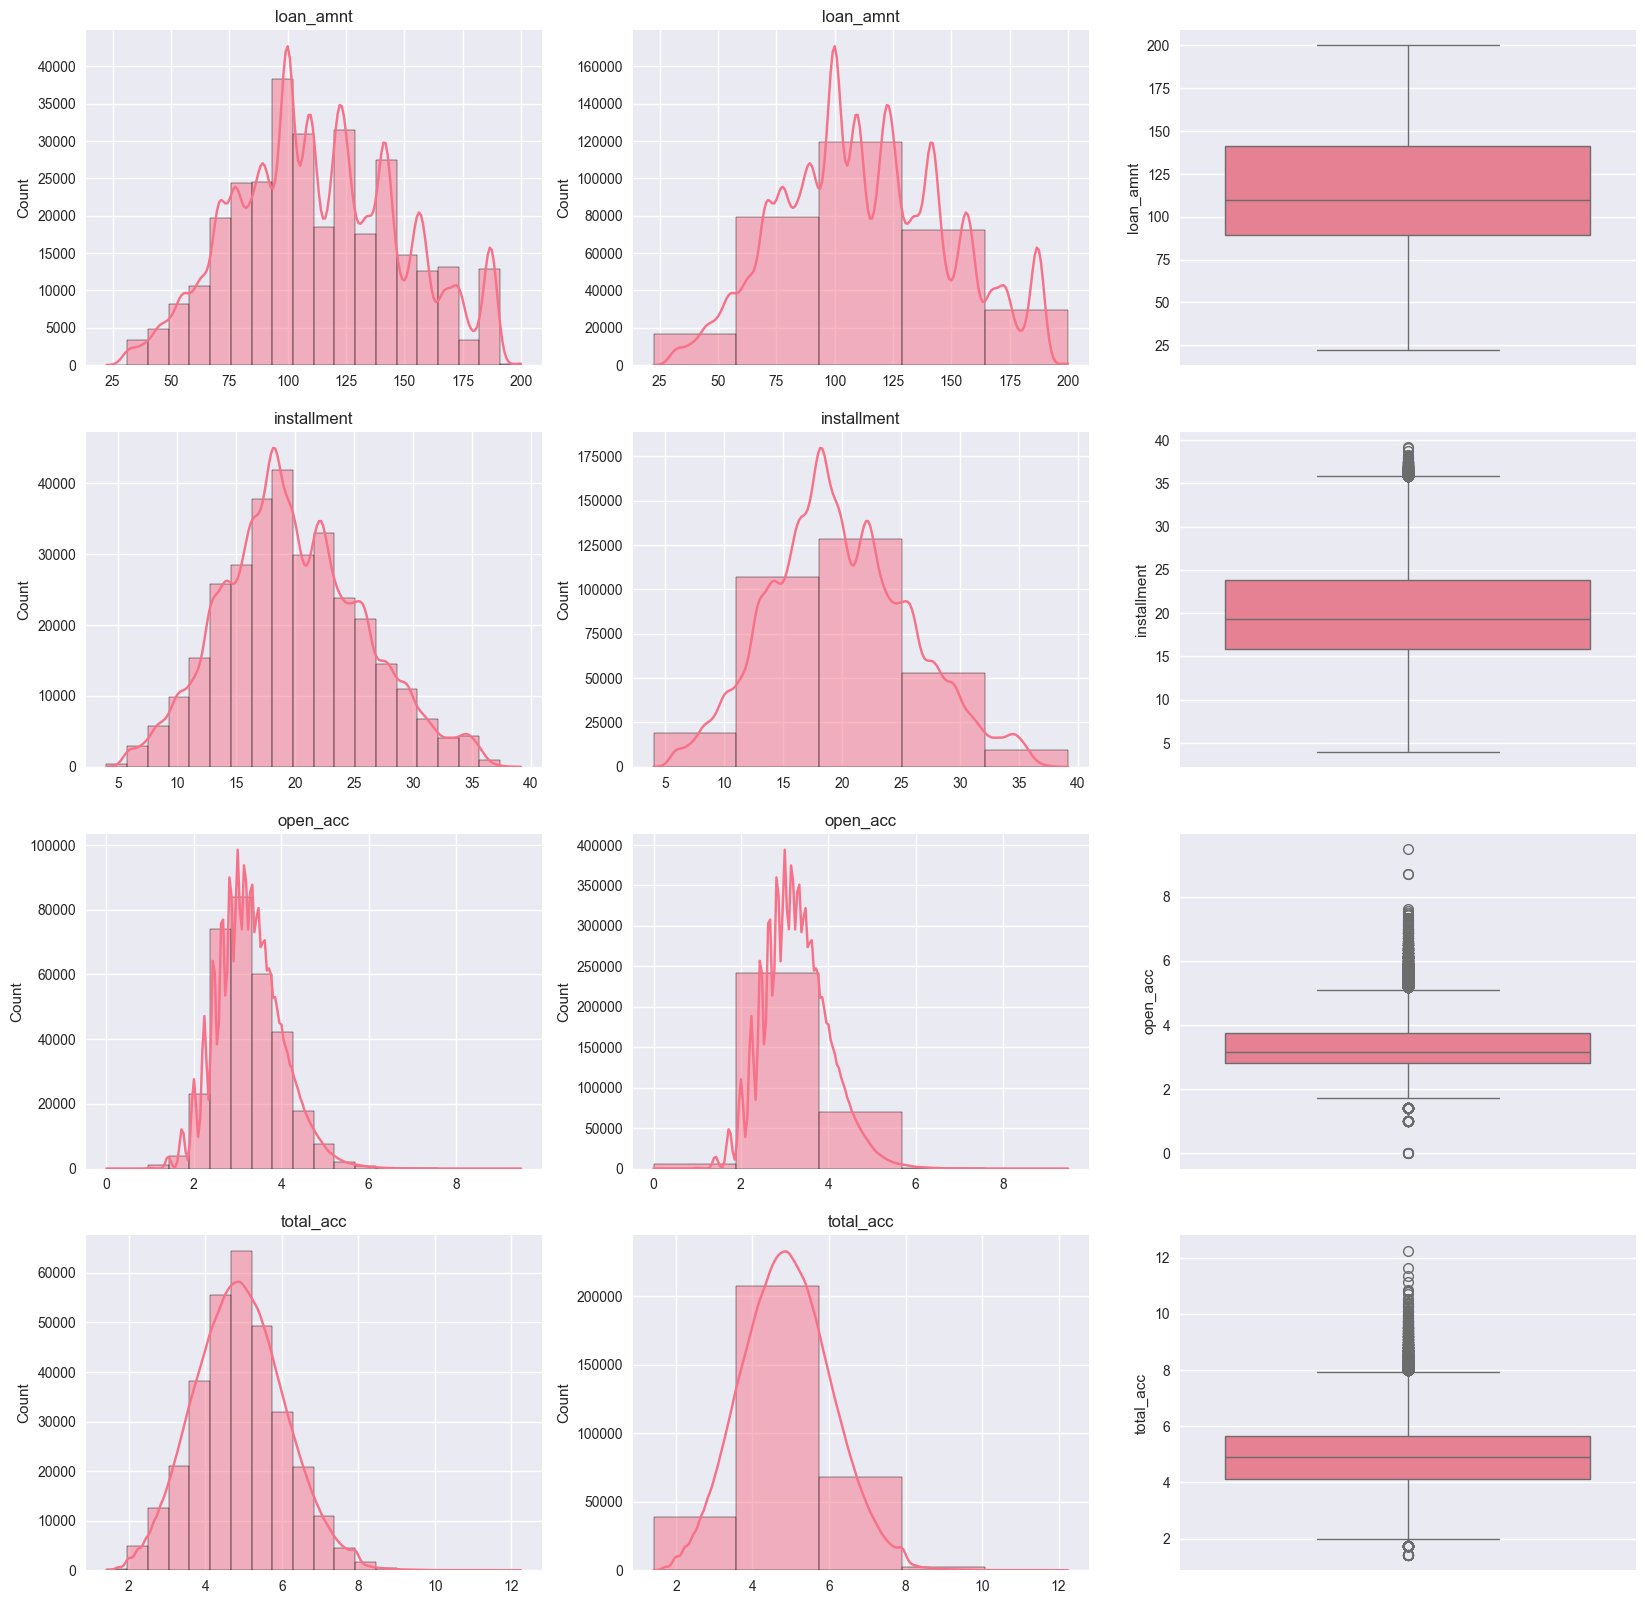

In [34]:
# As there seems to be still some amount of outliers in "loan_amnt","installment","open_acc","total_acc"even after applying log transformation, trying square root
# Box Plot and Distplots for numerical features  "loan_amnt","installment","open_acc","total_acc"
num_columns = ["loan_amnt","installment","open_acc","total_acc"]
fig, ax =plt.subplots(4,3)
fig.set_figheight(20)
fig.set_figwidth(20)
for col in range(len(num_columns)):
    sns.histplot(loan_data[num_columns[col]].apply(lambda x: math.sqrt(x)).rename(''),ax = ax[col][0],kde = True,bins = 20)
    sns.histplot(loan_data[num_columns[col]].apply(lambda x: math.sqrt(x)).rename(''),ax = ax[col][1],kde = True,bins = 5)
    sns.boxplot(loan_data[num_columns[col]].apply(lambda x: math.sqrt(x)), ax = ax[col][2])
    ax[col][0].set_title(num_columns[col])
    ax[col][1].set_title(num_columns[col])

In [35]:
# Correlation between loan_amnt, int rate, installment, loan term
loan_main = loan_data[["loan_amnt","int_rate","installment"]]
loan_main['loan_term'] = loan_data['term'].apply(lambda x: int(x[1:3]))
loan_main.corr()

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\1168129553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_main['loan_term'] = loan_data['term'].apply(lambda x: int(x[1:3]))


,loan_amnt,int_rate,installment,loan_term
loan_amnt,1.000000,0.167141,0.95397,0.393228
int_rate,0.167141,1.000000,0.16120,0.432667
installment,0.953970,0.161200,1.00000,0.152610
loan_term,0.393228,0.432667,0.15261,1.000000


Insights about "loan_amnt","int_rate","installment","open_acc","total_acc"
*  Loan Amount is skewed towards the right and has some outliers. Comparing with Loan Status, the defaulted loans have a higher median loan amount (difference of about 2000) and less number of outliers.The less number of outliers might be due to less defaulted loan data compared with fully paid loans. After applying square root transformation these values have become less extreme.
*  Interest rate is also skewed right with many outliers (above 25). Comparing with Loan Status, the defaulted loans have a higher median interest rate (difference of about 2.5)  and less amount of outliers.The less amount of outliers might be due to less defaulted loan data compared with fully paid loans. After appylying log transformation these values have become less estreme.
*  There is high correlation between loan amount and installment.As Installment is a function of interest rate, loan amount and loan term , we can remove it for prediction as it may cause multicollinearity. Although the median installment is higher for defaulted loans.
*   Open accounts are right skewwd with mean and median around 20. On comparing with Loan status the values in defulated loans  are distributed very  similiar to fully paid ones. But Fully paid ones seem to have a lot more outliers. We can cap the data at 25 to handle outliersas transformations seem to create more outliers.
*  Total accounts are also right skewwd with mean and median around 20. On comparing with Loan status the values in defulated loans  are distributed very  similiar to fully paid ones. But Fully paid ones seem to have a lot more outliers. We can cap the data at 55 to handle outliers as transformations seem to create more outliers.
* We can also create interaction terms between features for prediction.

Unique categories: 14
Frequency of categories in purpose                     loan_status   count
loan_purpose                           
debt_consolidation     0.792798  187527
credit_card            0.832844   66393
home_improvement       0.829504   19326
other                  0.785841   16894
major_purchase         0.838989    7043
small_business         0.703639    4562
car                    0.864829    3773
medical                0.779716    3382
moving                 0.766593    2275
vacation               0.808564    1985
house                  0.798975    1756
wedding                0.880670    1433
renewable_energy       0.766917     266
educational            0.842105     209


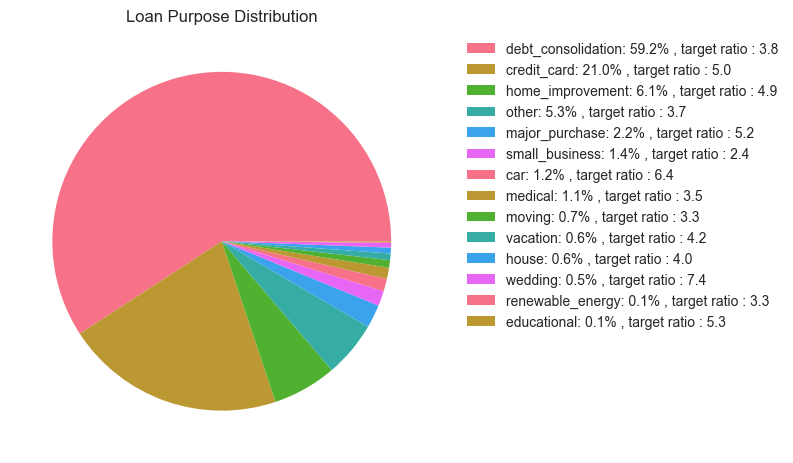

In [36]:
# Loan Purpose Distribution
print("Unique categories:",loan_data['purpose'].nunique())
loan_purp = pd.DataFrame(loan_data['purpose']).rename(columns={'purpose':'loan_purpose'})
loan_purp['loan_status'] = y_train_encoded
# Frequency for each category
loan_purp_freq= pd.DataFrame(loan_purp.groupby('loan_purpose')['loan_status'].mean())
loan_purp_freq['count'] = loan_purp['loan_purpose'].value_counts()

loan_purp_freq =  loan_purp_freq.sort_values(by = 'count',ascending=False)
print("Frequency of categories in purpose",loan_purp_freq)
plt.pie(loan_purp_freq['count'],labels= None)
labels = [(i[0] +': '+ str(round(i[2]*100/len(loan_data),1)) + '% , target ratio : ' + str(round(i[1]/(1-i[1]),1) )) for i in loan_purp_freq.reset_index().values]
plt.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Loan Purpose Distribution')
plt.show()

In [37]:
# As there are 14 categories,one hot encoding adds 14 more columns, to reduce the number comparing association of loan purpose column with target for different number of categories considered
for i in [2,4,6,8,10,12,13,14]:
    sig_loan_purpose = loan_purp_freq.index[:i]
    sig_loan_purpose_column = loan_data['purpose'].apply(lambda x : x if x in sig_loan_purpose else 'Others')
    loan_purp_encoder = LabelEncoder()
    loan_purp_encoded = loan_purp_encoder.fit_transform(sig_loan_purpose_column)
    print("Association between Loan Purpose when top ",i,"categories are considered:",association(np.array([loan_purp_encoded+1,y_train_encoded+1]).T,method='cramer'))

Association between Loan Purpose when top  2 categories are considered: 0.21978139443412048
Association between Loan Purpose when top  4 categories are considered: 0.20037306715669145
Association between Loan Purpose when top  6 categories are considered: 0.2068205414754561
Association between Loan Purpose when top  8 categories are considered: 0.18453353749788645
Association between Loan Purpose when top  10 categories are considered: 0.18926933105252505
Association between Loan Purpose when top  12 categories are considered: 0.1972060988099116
Association between Loan Purpose when top  13 categories are considered: 0.20007976526815777
Association between Loan Purpose when top  14 categories are considered: 0.26589474983467803


Loan Purpose Insights
*  Loan Purpose has 14 categories with varying fully paid to default ratio.
*  The association between loan purpose and target is highest when considering all 14 categories.
*  We can use one hot encoding for loan purpose.

<Axes: ylabel='annual_inc'>

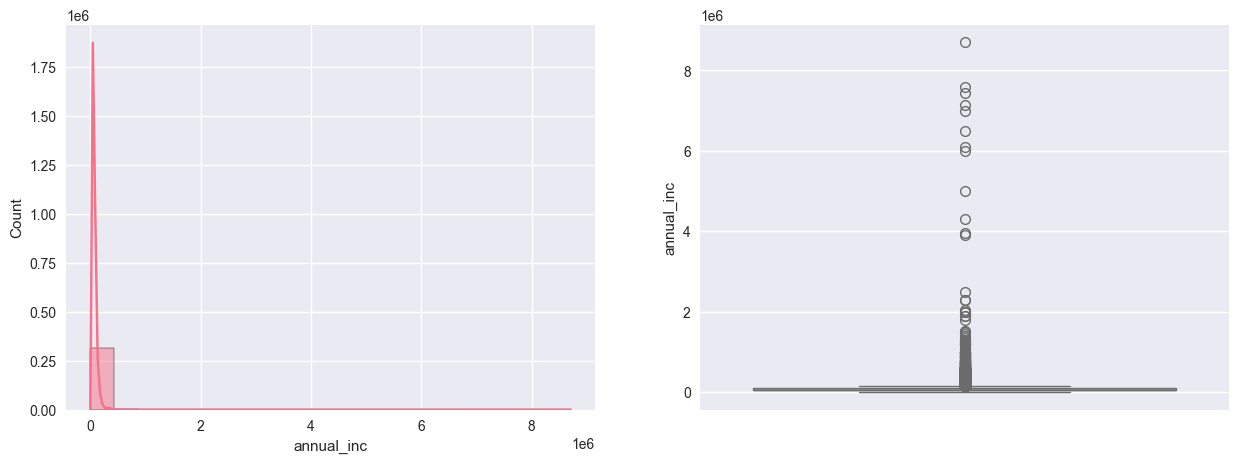

In [38]:
# For Annual Income. Plotting Histogram and boxplot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['annual_inc'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['annual_inc'],ax=axes[1])


<Axes: >

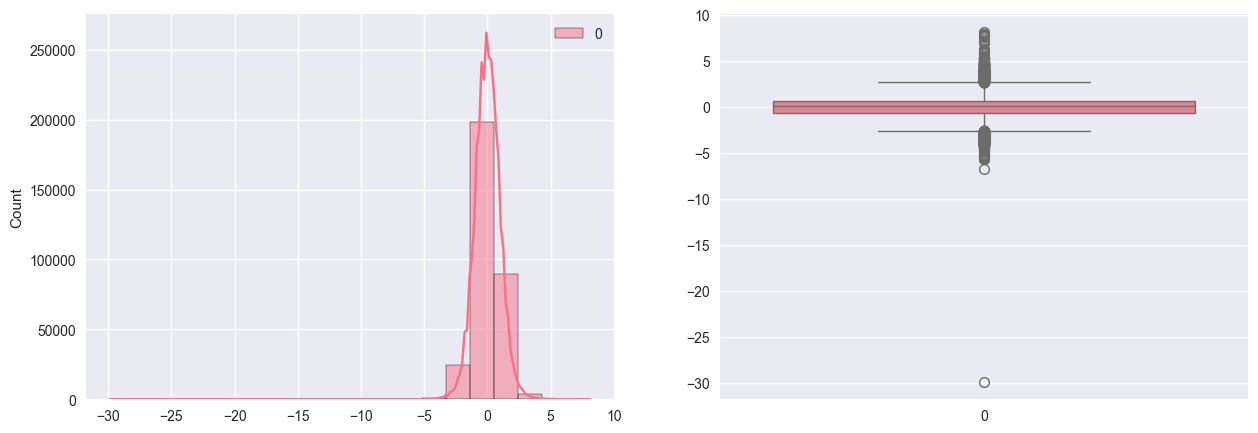

In [39]:
# Annual income seems to have lot of outliers skewing the distribution. Applying BOX COX transformation
# For Annual Income. Plotting Histogram and boxplot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
ann_inc_transformed = power_transform((loan_data['annual_inc']+1).values.reshape(-1, 1),method = "box-cox")
sns.histplot(ann_inc_transformed,kde = True, bins = 20,ax = axes[0])
sns.boxplot(ann_inc_transformed,ax=axes[1])


10th - Quartile  min: 120037.0  max: 8706582.0  Target ratio:  6.1
1th - Quartile  min: 0.0  max: 34000.0  Target ratio:  2.98
2th - Quartile  min: 34008.0  max: 42000.0  Target ratio:  3.17
3th - Quartile  min: 42008.0  max: 50000.0  Target ratio:  3.57
4th - Quartile  min: 50001.0  max: 55403.0  Target ratio:  3.81
5th - Quartile  min: 55404.0  max: 64000.0  Target ratio:  3.93
6th - Quartile  min: 64008.0  max: 72000.0  Target ratio:  4.19
7th - Quartile  min: 72002.0  max: 82000.0  Target ratio:  4.54
8th - Quartile  min: 82000.88  max: 97000.0  Target ratio:  5.13
9th - Quartile  min: 97017.0  max: 120000.0  Target ratio:  5.38


<Axes: xlabel='Annual Income - Quartile binned', ylabel='Count'>

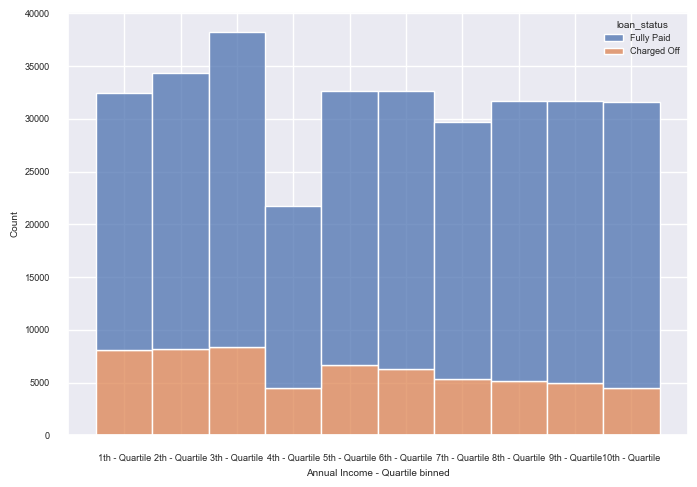

In [40]:
# As box cox transformation caused more outliers, we can convert the annual income into different quartile bins
ann_inc = pd.DataFrame(loan_data['annual_inc'])
ann_inc['qb_ann_inc']=pd.qcut(loan_data['annual_inc'], q=10, labels=[str(i) + 'th - Quartile'  for i in range(1,11)])
ann_inc['loan_status'] = y_train
for i in sorted(list(ann_inc['qb_ann_inc'].unique())):
    target_freq = ann_inc[ann_inc['qb_ann_inc']==i].groupby('loan_status')['loan_status'].count()

    print(i,' min:',ann_inc[ann_inc['qb_ann_inc']==i]['annual_inc'].min(),' max:', ann_inc[ann_inc['qb_ann_inc']==i]['annual_inc'].max(),
          ' Target ratio: ',round(target_freq['Fully Paid']/target_freq['Charged Off'],2))

sns.set(font_scale=0.6)
# Visualizing annual income quantile binned along with loan status
ann_inc = ann_inc.rename(columns={'qb_ann_inc':'Annual Income - Quartile binned'})
sns.histplot(ann_inc,multiple='stack',x = 'Annual Income - Quartile binned',hue = 'loan_status')

Annual Income Insights
*  Annual income varies from 0 to 1000000 and most values lie between 34000 to 97000.
*  As there are lot of outliers ,applied box cox  transformation , which didnt capture all the outliers.
*  Converted the column into a categorical column with quartile binning of the annual income values.
* The column appears to be equally distributed between the bins when the number of bins is chosen as 10.
* Target ratio of full paid to defaulted loans increases with higher annual income range
*   We can use this categorical column , apply one hot encoding and use that in our Logistic model.

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\2528816810.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  issue_date = pd.to_datetime(loan_data['issue_d'])


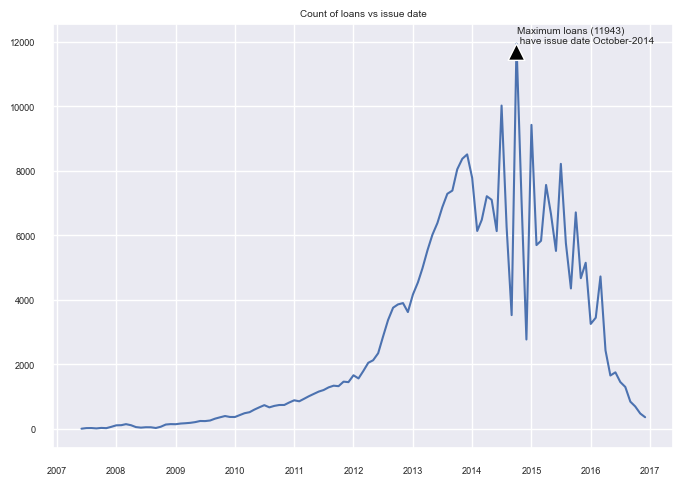

In [41]:
# Visualizing issue date , Plotting No of loans with issue dates
issue_date = pd.to_datetime(loan_data['issue_d'])
plt.plot(issue_date.value_counts().sort_index())
plt.title('Count of loans vs issue date')
max_value = issue_date.value_counts().max()
max_date = issue_date.value_counts().idxmax()
plt.annotate(f'Maximum loans ({max_value})\n have issue date {max_date.month_name()}-{max_date.year}', xy=(max_date, max_value),
             xytext=(max_date, max_value + 5),
             arrowprops=dict(facecolor='black'))
plt.show()

<Axes: xlabel='issue_d'>

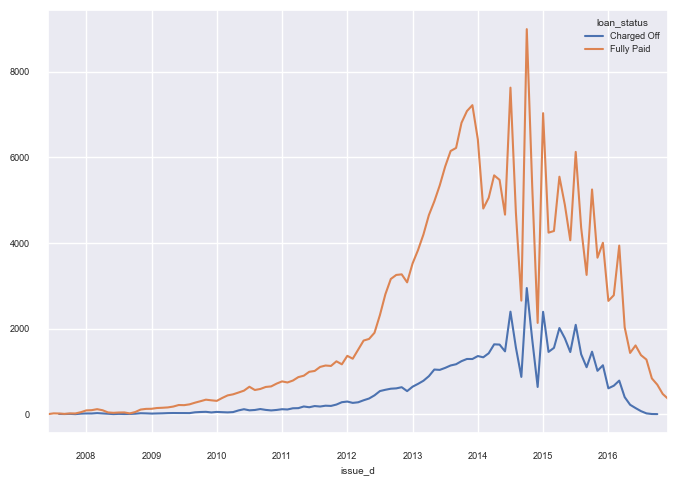

In [42]:
# Plotting loan status numbers with issue date
issue_date  = pd.DataFrame(issue_date)
issue_date['loan_status'] = y_train
freq = issue_date.groupby([issue_date['issue_d'].dt.to_period('M'),'loan_status'])['loan_status'].count()
freq.unstack().plot()

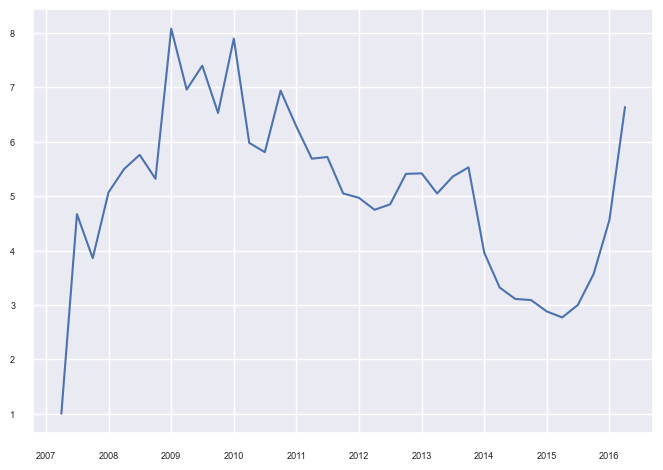

In [43]:
# Plotting Fully paid to Charged off ratio with Quarters of issue date
freq_quarter = issue_date.groupby([issue_date['issue_d'].dt.to_period('Q'),'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_quarter.index.levels[0].to_timestamp()[:-2],[round(freq_quarter[i].get('Fully Paid',1)/(freq_quarter[i].get('Charged Off',0)+1 ),2) for i in freq_quarter.index.levels[0]][:-2])

In [44]:
# Issue date UYear range
pd.to_datetime(df['issue_d']).apply(lambda x: x.year).unique()

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\1168974485.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df['issue_d']).apply(lambda x: x.year).unique()


array([2015, 2014, 2013, 2012, 2016, 2011, 2010, 2008, 2009, 2007])

Issue Date Insights
*  The dataset has issue dates  with years ranging from 2007 to 2016.
*  The number of loans per date seems to hit maximum around 2015
*  Converting to different quarters and plotting target ratio the ratio varies between 1 to 8.
*  We can apply one hot encoding for the year and quarter of issue date for preprocessing

count    3.168240e+05
mean     1.581182e+04
std      2.032492e+04
min      0.000000e+00
25%      6.031000e+03
50%      1.117400e+04
75%      1.961900e+04
max      1.298783e+06
Name: revol_bal, dtype: float64


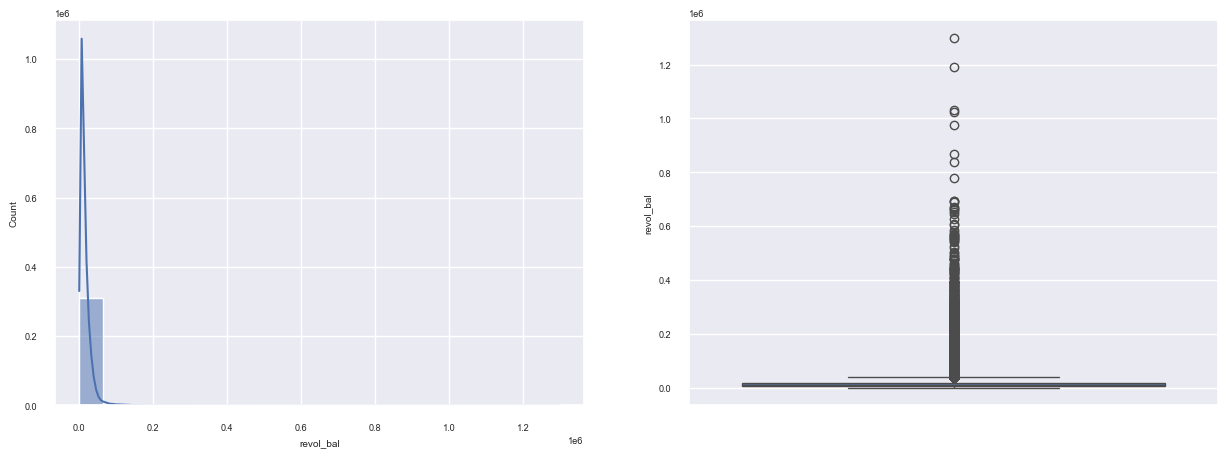

In [45]:
# For Revolving Balance ,plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set(font_scale=1)
sns.histplot(loan_data['revol_bal'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_bal'],ax=axes[1])
print(loan_data['revol_bal'].describe())

<Axes: >

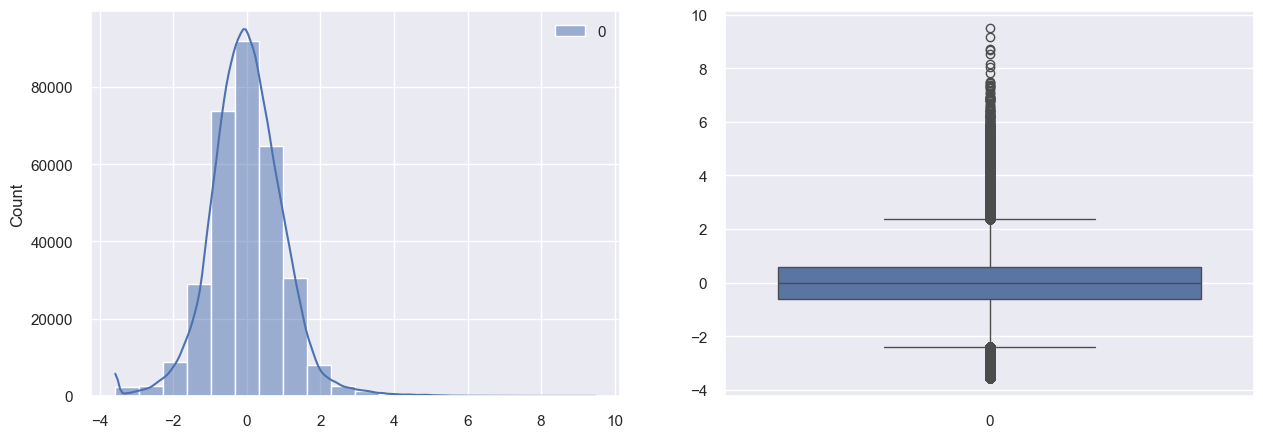

In [46]:
# As there seems to lot of outliers applying log transformation,plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set(font_scale=1)
sns.histplot(power_transform(loan_data['revol_bal'].values.reshape(-1, 1),method = "yeo-johnson"),kde = True, bins = 20,ax = axes[0])
sns.boxplot(power_transform(loan_data['revol_bal'].values.reshape(-1, 1),method = "yeo-johnson"),ax=axes[1])


1th - Quartile  min: 0.0  max: 6031.0  Target ratio:  4.26
2th - Quartile  min: 6032.0  max: 11174.0  Target ratio:  4.02
3th - Quartile  min: 11175.0  max: 19619.0  Target ratio:  3.97
4th - Quartile  min: 19620.0  max: 1298783.0  Target ratio:  4.15


<Axes: xlabel='Revolving Balance - Quartile binned', ylabel='Count'>

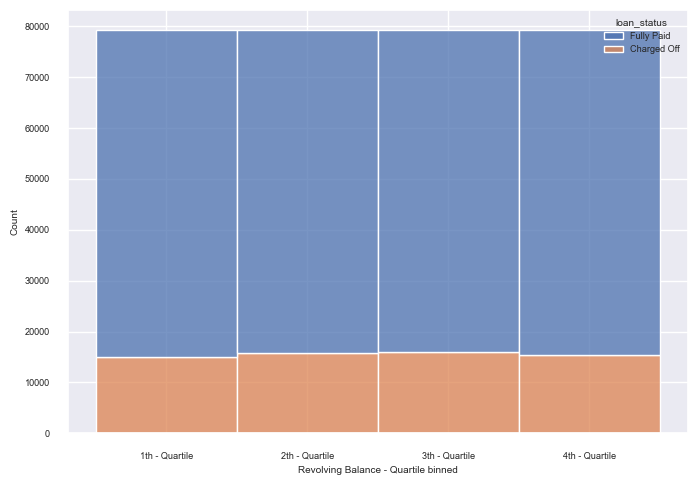

In [47]:
# As box cox transformation caused more outliers, we can convert the revolving balance into different quartile bins
rev_bal = pd.DataFrame(loan_data['revol_bal'])
rev_bal['qb_rev_bal']=pd.qcut(loan_data['revol_bal'], q=4, labels=[str(i) + 'th - Quartile'  for i in range(1,5)])
rev_bal['loan_status'] = y_train
for i in sorted(list(rev_bal['qb_rev_bal'].unique())):
    target_freq = rev_bal[rev_bal['qb_rev_bal']==i].groupby('loan_status')['loan_status'].count()

    print(i,' min:',rev_bal[rev_bal['qb_rev_bal']==i]['revol_bal'].min(),' max:', rev_bal[rev_bal['qb_rev_bal']==i]['revol_bal'].max(),
          ' Target ratio: ',round(target_freq['Fully Paid']/target_freq['Charged Off'],2))

sns.set(font_scale=0.6)
# Visualizing Revolving Balance quantile binned along with loan status
rev_bal = rev_bal.rename(columns={'qb_rev_bal':'Revolving Balance - Quartile binned'})
sns.histplot(rev_bal,multiple='stack',x = 'Revolving Balance - Quartile binned',hue = 'loan_status')

Revolving Balance Insights
*  Revolving Balance varies from 0 to 1000000 and most values lie below 50000
*  As there are lot of outliers ,applied box cox  transformation , which didnt capture all the outliers.
*  Converted the column into a categorical column with quartile binning of the revolving balance values.
* The column appears to be equally distributed between the bins when the number of bins is chosen as 4.
* Target ratio of full paid to defaulted loans varies very little.
*   We can use this categorical column , apply one hot encoding and use that in our Logistic model.

count    316824.000000
mean         17.379026
std          19.522739
min           0.000000
25%          11.280000
50%          16.910000
75%          22.970000
max        9999.000000
Name: dti, dtype: float64

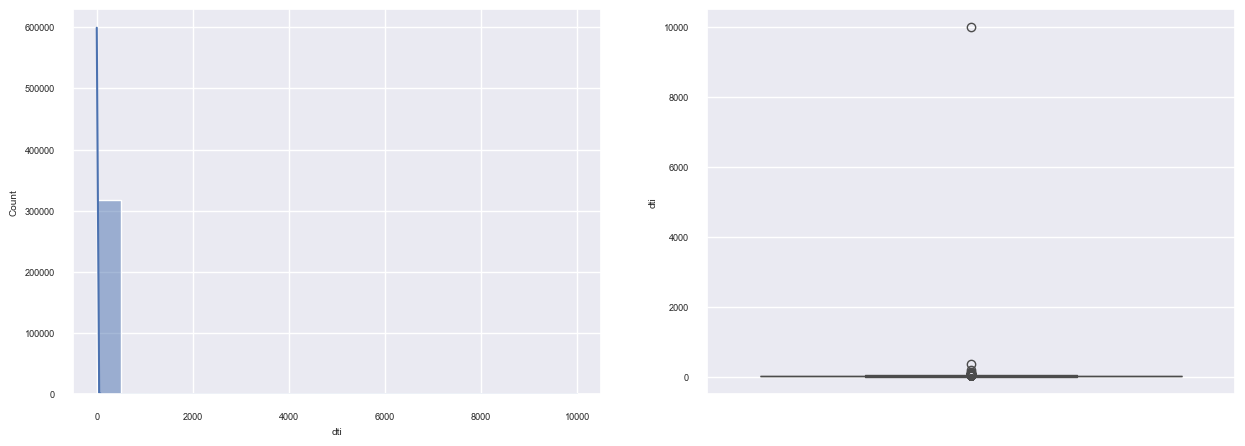

In [48]:
# For Debt to incmome.Plotting Histogram and box plot
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['dti'],kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['dti'],ax=axes[1])
loan_data['dti'].describe()

<Axes: ylabel='dti'>

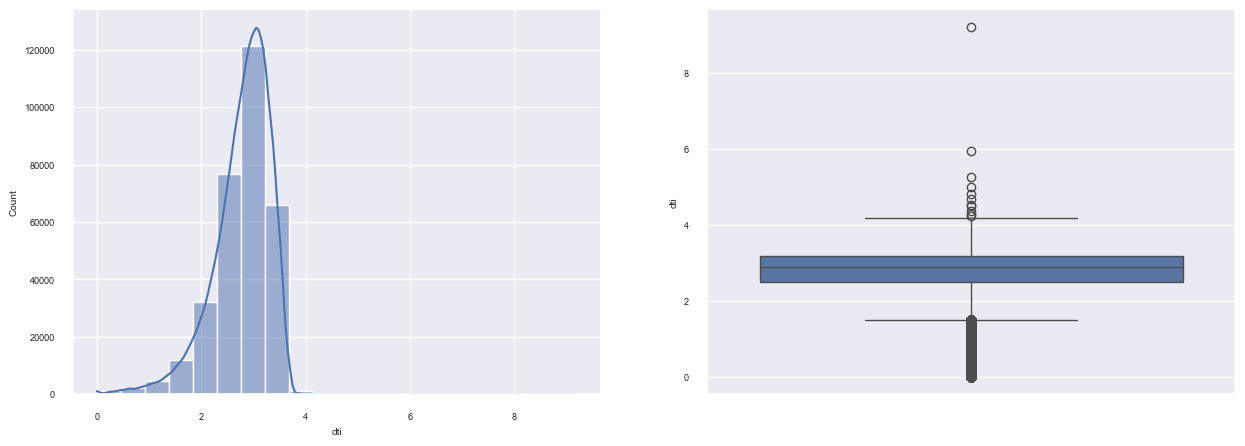

In [49]:
# As there seems to be lot of outliers applying power_transform
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['dti'].apply(lambda x: math.log(x+1)),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['dti'].apply(lambda x: math.log(x+1)),ax=axes[1])


1  min: 0.0  max: 10.01  Target ratio:  6.32
2  min: 10.02  max: 14.7  Target ratio:  5.24
3  min: 14.71  max: 19.16  Target ratio:  4.42
4  min: 19.17  max: 24.47  Target ratio:  3.65
5  min: 24.48  max: 9999.0  Target ratio:  2.52


<Axes: xlabel='Debt to Income - Quartile binned', ylabel='Count'>

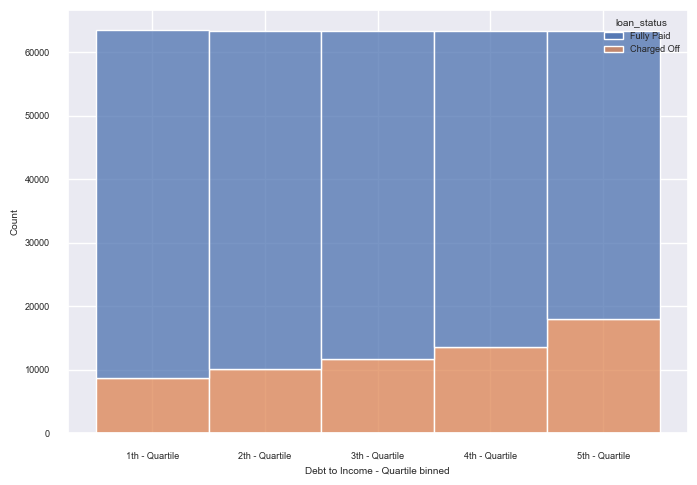

In [50]:
# As box cox transformation caused more outliers, we can convert the Debt to Income into different quartile bins
dti = pd.DataFrame(loan_data['dti'])
k = 5
dti['qb_dti']=pd.qcut(loan_data['dti'], q=k, labels=[str(i) + 'th - Quartile'  for i in range(1,k+1)])
dti['loan_status'] = y_train
for i in range(1,k+1):
    target_freq = dti[dti['qb_dti']==(str(i) + 'th - Quartile')].groupby('loan_status')['loan_status'].count()

    print(i,' min:',dti[dti['qb_dti']==(str(i) + 'th - Quartile')]['dti'].min(),' max:', dti[dti['qb_dti']==(str(i) + 'th - Quartile')]['dti'].max(),
          ' Target ratio: ',round(target_freq['Fully Paid']/target_freq['Charged Off'],2))

sns.set(font_scale=0.6)
# Visualizing Debt to Income quantile binned along with loan status
dti = dti.rename(columns={'qb_dti':'Debt to Income - Quartile binned'})
sns.histplot(dti,multiple='stack',x = 'Debt to Income - Quartile binned',hue = 'loan_status')

Debt to Income Insights
*  Debt to income varies from 0 to 10000 and most values lie below 50
*  As there are lot of outliers ,applied box cox  transformation , which didnt capture all the outliers.
*  Converted the column into a categorical column with quartile binning of the debt to income values.
* The column appears to be equally distributed between the bins when the number of bins is chosen as 5.
* Target ratio of full paid to defaulted decreases with dti, and the binning captures the pattern.
*   We can use this categorical column , apply one hot encoding and use that in our Logistic model.

count    316592.000000
mean         53.770073
std          24.431364
min           0.000000
25%          35.800000
50%          54.800000
75%          72.900000
max         153.000000
Name: revol_util, dtype: float64
Percentage missing in Revolving Utilization: 0.07322677574931193


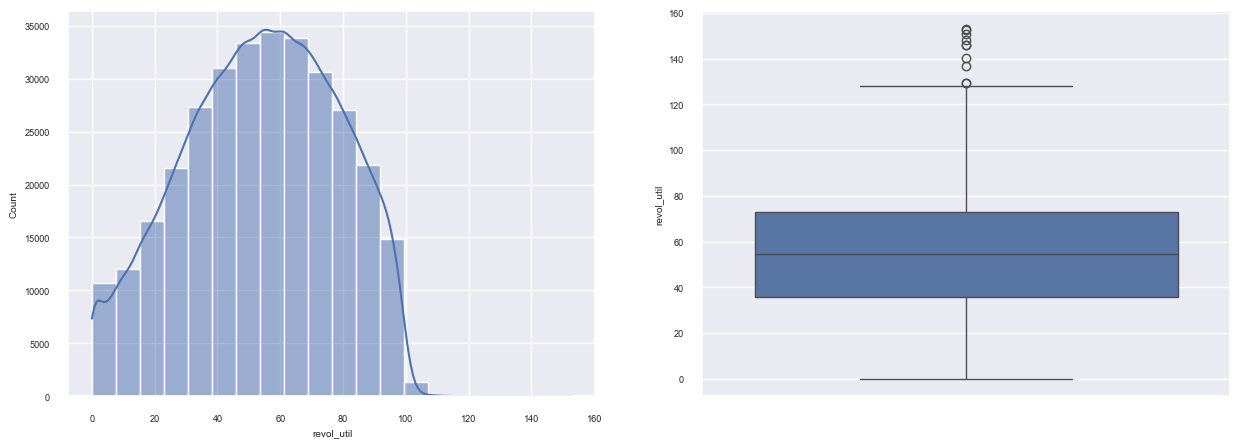

In [51]:
# For Revolving Utilization , plotting boxplot and histogram
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['revol_util'].dropna(),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_util'].dropna(),ax=axes[1])
print(loan_data['revol_util'].describe())
print("Percentage missing in Revolving Utilization:", loan_data['revol_util'].isnull().sum() * 100 / loan_data.shape[0])

<Axes: ylabel='revol_util'>

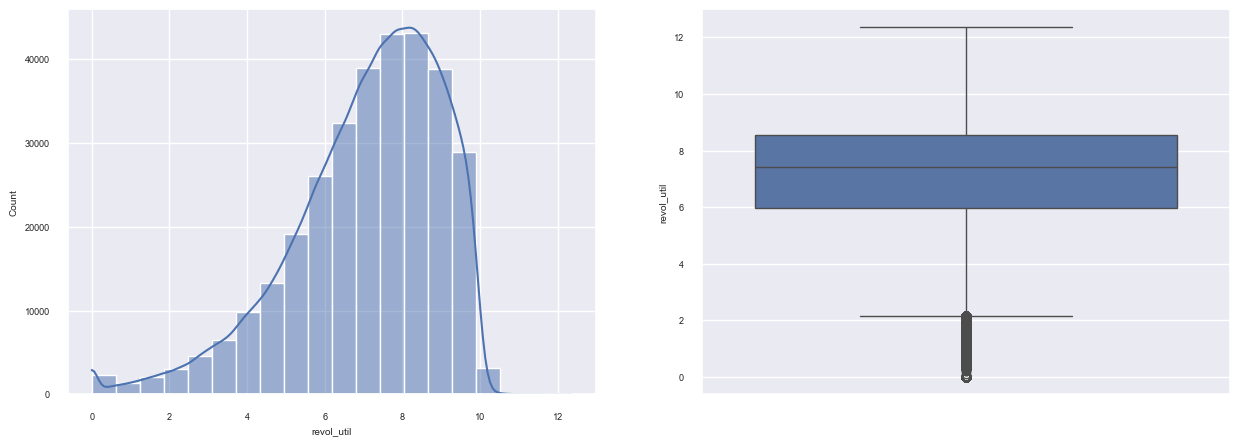

In [52]:
# For Revolving Utilization , plotting boxplot and histogram
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(loan_data['revol_util'].dropna().apply(lambda x: math.sqrt(x)),kde = True, bins = 20,ax = axes[0])
sns.boxplot(loan_data['revol_util'].dropna().apply(lambda x: math.sqrt(x)),ax=axes[1])


<Axes: >

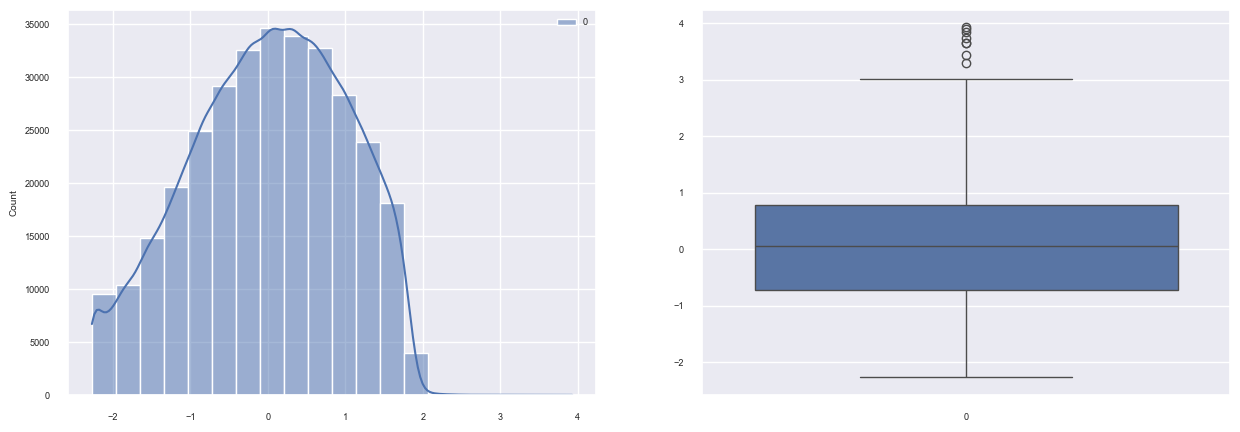

In [53]:
# For Revolving Utilization , plotting boxplot and histogram
fig,axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.histplot(power_transform(loan_data['revol_util'].values.reshape(-1,1),method='yeo-johnson'),kde = True, bins = 20,ax = axes[0])
sns.boxplot(power_transform(loan_data['revol_util'].values.reshape(-1,1),method='yeo-johnson'),ax=axes[1])


1  min: 0.0  max: 19.7  Target ratio:  6.68
2  min: 19.8  max: 31.3  Target ratio:  5.37
3  min: 31.4  max: 40.0  Target ratio:  4.75
4  min: 40.1  max: 47.7  Target ratio:  4.29
5  min: 47.8  max: 54.8  Target ratio:  4.05
6  min: 54.9  max: 61.8  Target ratio:  3.86
7  min: 61.9  max: 69.0  Target ratio:  3.68
8  min: 69.1  max: 76.9  Target ratio:  3.54
9  min: 77.0  max: 86.2  Target ratio:  3.4
10  min: 86.3  max: 153.0  Target ratio:  3.06


<Axes: xlabel='Revolving Util - Quartile binned', ylabel='Count'>

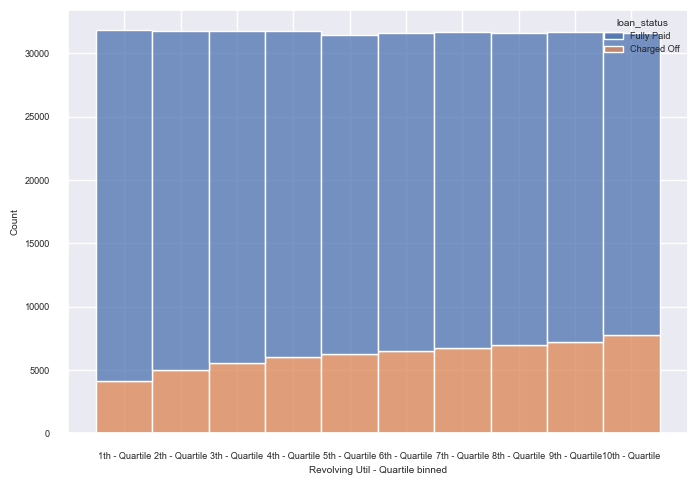

In [54]:
# As box cox transformation caused more outliers, we can convert the Revolving Util into different quartile bins
revol_util = pd.DataFrame(loan_data['revol_util'])
k = 10
revol_util['qb_revol_util']=pd.qcut(loan_data['revol_util'], q=k, labels=[str(i) + 'th - Quartile'  for i in range(1,k+1)])
revol_util['loan_status'] = y_train
for i in range(1,k+1):
    target_freq = revol_util[revol_util['qb_revol_util']==(str(i) + 'th - Quartile')].groupby('loan_status')['loan_status'].count()

    print(i,' min:',revol_util[revol_util['qb_revol_util']==(str(i) + 'th - Quartile')]['revol_util'].min(),' max:', revol_util[revol_util['qb_revol_util']==(str(i) + 'th - Quartile')]['revol_util'].max(),
          ' Target ratio: ',round(target_freq['Fully Paid']/target_freq['Charged Off'],2))

sns.set(font_scale=0.6)
# Visualizing Revolving Util quantile binned along with loan status
revol_util = revol_util.rename(columns={'qb_revol_util':'Revolving Util - Quartile binned'})
sns.histplot(revol_util,multiple='stack',x = 'Revolving Util - Quartile binned',hue = 'loan_status')

Revolving Utilization Insights
*  Revolving Utilization varies from 0 to 154 and most values lie below 100
*  As there are lot of outliers ,applied box cox  transformation , which didnt capture all the outliers.
*  Converted the column into a categorical column with quartile binning of the revol_util values.
* The column appears to be equally distributed between the bins when the number of bins is chosen as 10.
* Target ratio of full paid to defaulted decreases with revol_util, and the binning captures the pattern.
*   We can use this categorical column , apply one hot encoding and use that in our Logistic model.
* As there are very little missing values , we can impute the missing values with the median category here it will be the the median bin 5th Quartile

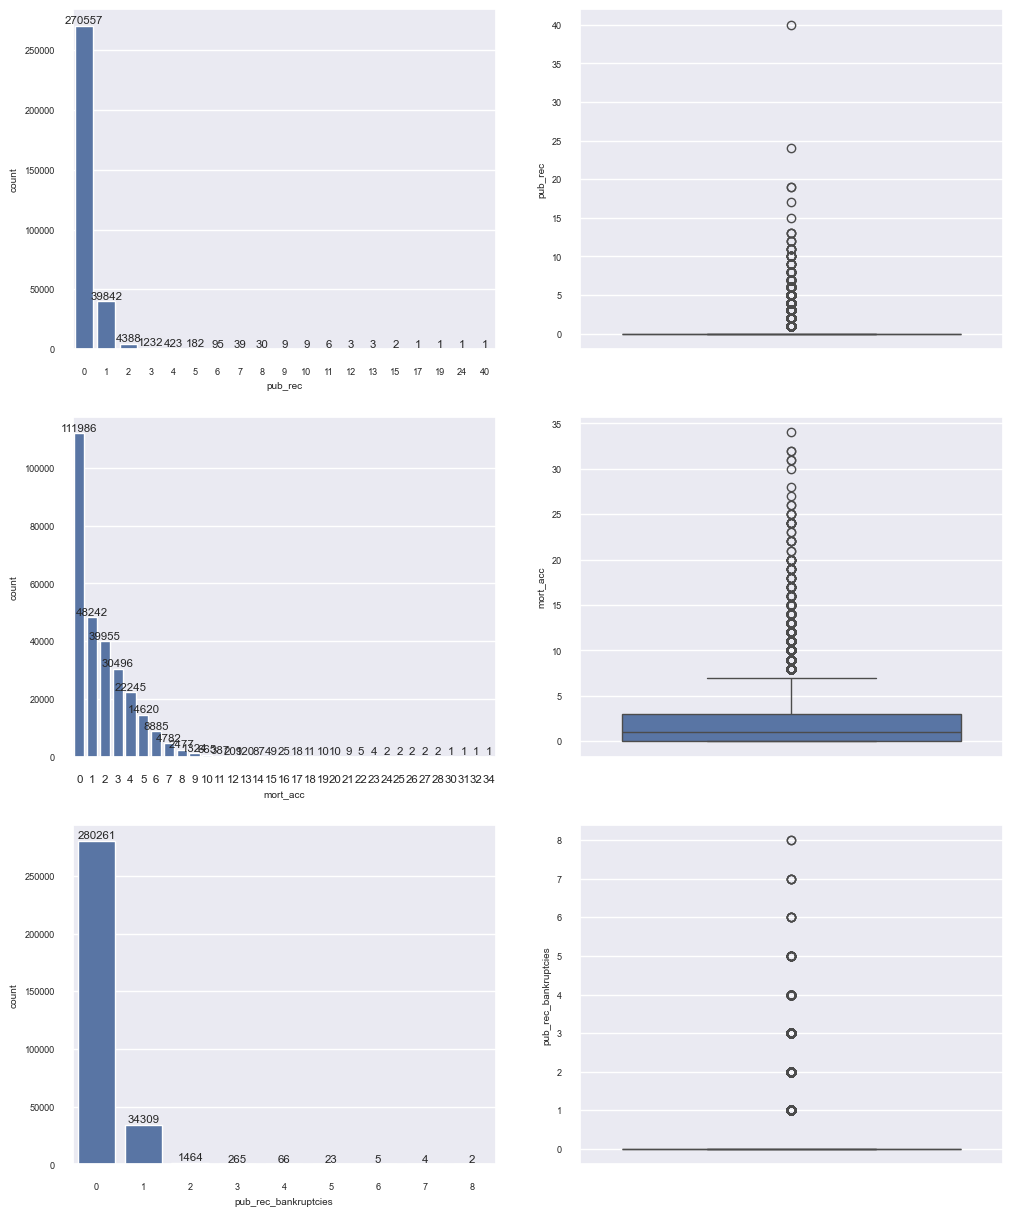

In [55]:
# Visualizing frequencies of values in  Pub_rec, Mort_acc, Pub_rec_bankruptcies
fig,axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(12)
pub_rec = loan_data['pub_rec'].apply(int).value_counts()
sns.set(font_scale=1)
sns.barplot(pub_rec,ax=axes[0][0])
axes[0][0].bar_label(axes[0][0].containers[0], pub_rec.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec'],ax=axes[0][1])

mort_acc = loan_data['mort_acc'].dropna().apply(int).value_counts()
sns.barplot(mort_acc,ax=axes[1][0])
axes[1][0].bar_label(axes[1][0].containers[0], mort_acc.values, fontsize = 'x-small')
axes[1][0].tick_params(axis = 'x',labelsize = 'x-small')
sns.boxplot(loan_data['mort_acc'].dropna(),ax=axes[1][1])

pub_ban = loan_data['pub_rec_bankruptcies'].dropna().apply(int).value_counts()
sns.barplot(pub_ban,ax=axes[2][0])
axes[2][0].bar_label(axes[2][0].containers[0], pub_ban.values, fontsize = 'x-small')
sns.boxplot(loan_data['pub_rec_bankruptcies'].dropna(),ax=axes[2][1])

plt.show()

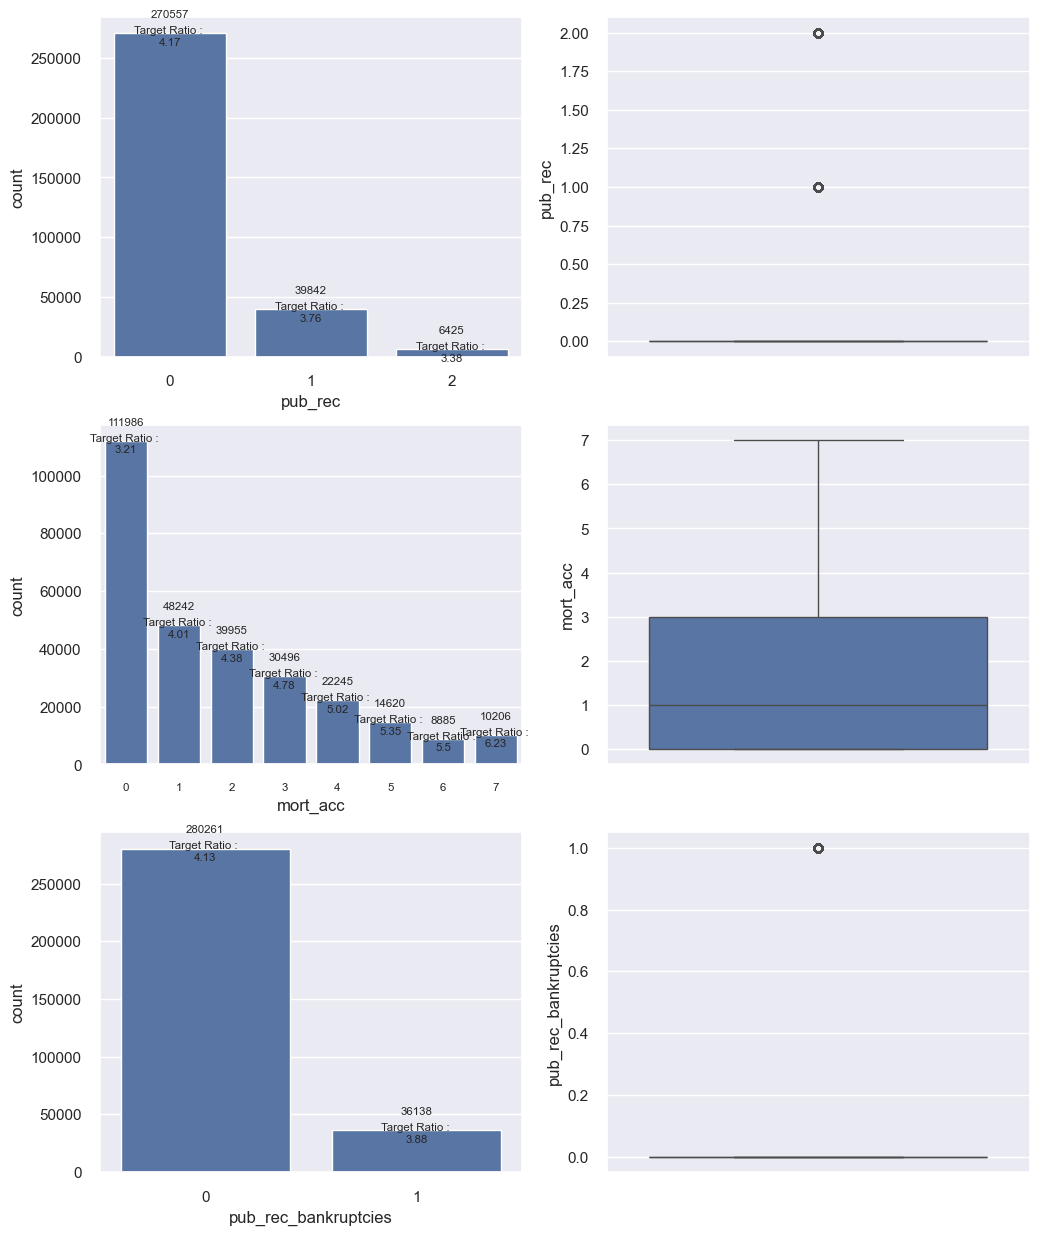

In [56]:
# Capping the data at 99th percentile for values in  Pub_rec, Mort_acc, Pub_rec_bankruptcies

fig,axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(12)
sns.set(font_scale=1)

pub_rec_upper_limit = loan_data['pub_rec'].apply(int).quantile(0.99)
pub_rec_capped = loan_data['pub_rec'].apply(int).clip(0, pub_rec_upper_limit)
pub_rec_capped = pd.DataFrame(pub_rec_capped)
pub_rec_capped['loan_status'] = y_train_encoded
target_pub_rec = pub_rec_capped.groupby('pub_rec')['loan_status'].apply(lambda x: round(x.sum()/(x.count()-x.sum()),2) )
sns.barplot(pub_rec_capped['pub_rec'].value_counts(),ax=axes[0][0])
axes[0][0].bar_label(axes[0][0].containers[0], pub_rec_capped['pub_rec'].value_counts().values, fontsize = 'x-small',padding = 10)
sns.boxplot(pub_rec_capped['pub_rec'],ax=axes[0][1])
axes[0][0].bar_label(axes[0][0].containers[0], ['Target Ratio : \n'+ str(i) for i in target_pub_rec.values], fontsize = 'x-small', padding = -10)


mort_acc_upper_limit = loan_data['mort_acc'].quantile(0.98)
mort_acc_capped = loan_data['mort_acc'].clip(0, mort_acc_upper_limit)
mort_acc_capped = pd.DataFrame(mort_acc_capped)
mort_acc_capped['loan_status'] = y_train_encoded
mort_acc_capped = mort_acc_capped.dropna(how = 'any',axis = 0)
mort_acc_capped['mort_acc'] = mort_acc_capped['mort_acc'].apply(int)
target_mort_acc = mort_acc_capped.groupby('mort_acc')['loan_status'].apply(lambda x: round(x.sum()/(x.count()-x.sum()),2) )
sns.barplot(mort_acc_capped['mort_acc'].value_counts(),ax=axes[1][0])
axes[1][0].bar_label(axes[1][0].containers[0], mort_acc_capped['mort_acc'].value_counts().sort_index().values, fontsize = 'x-small',padding = 10)
axes[1][0].tick_params(axis = 'x',labelsize = 'x-small')
sns.boxplot(mort_acc_capped['mort_acc'],ax=axes[1][1])
axes[1][0].bar_label(axes[1][0].containers[0], ['Target Ratio : \n'+ str(i) for i in target_mort_acc.values], fontsize = 'x-small', padding = -10)


pub_rec_ban_upper_limit = loan_data['pub_rec_bankruptcies'].quantile(0.99)
pub_rec_ban_capped = loan_data['pub_rec_bankruptcies'].clip(0, pub_rec_ban_upper_limit)
pub_rec_ban_capped = pd.DataFrame(pub_rec_ban_capped)
pub_rec_ban_capped['loan_status'] = y_train_encoded
pub_rec_ban_capped = pub_rec_ban_capped.dropna(how = 'any',axis = 0)
pub_rec_ban_capped['pub_rec_bankruptcies'] = pub_rec_ban_capped['pub_rec_bankruptcies'].apply(int)
target_pub_rec_ban = pub_rec_ban_capped.groupby('pub_rec_bankruptcies')['loan_status'].apply(lambda x: round(x.sum()/(x.count()-x.sum()),2) )
sns.barplot(pub_rec_ban_capped['pub_rec_bankruptcies'].value_counts(),ax=axes[2][0])
axes[2][0].bar_label(axes[2][0].containers[0], pub_rec_ban_capped['pub_rec_bankruptcies'].value_counts().values, fontsize = 'x-small',padding = 10)
sns.boxplot(pub_rec_ban_capped['pub_rec_bankruptcies'],ax=axes[2][1])
axes[2][0].bar_label(axes[2][0].containers[0], ['Target Ratio : \n'+ str(i) for i in target_pub_rec_ban.values], fontsize = 'x-small', padding = -10)


plt.show()

Insights about Public records, Mortgage accounts, Pub_rec_bankruptcies
*  As there seems to lot of outliers in all three of these columns, applying percentile based capping.
* After capping the columns at 99th, 98th and 99th percentile respecrively. the outliers were reduced significantly.
* We can use simple median imputing for mortgage accounts and public recorded bankruptcies columns first and try to apply knn imputing later.
*  There seems to be some increase in number of defaulted loans with increase in public records and public recorded bankruptcies.
*  Also more mortgage accounts seems to indicate less defaluting on the loans.

In [57]:
# Loan Title Distribution
print("Unique categories:",loan_data['title'].nunique())
loan_title = pd.DataFrame(loan_data['title']).rename(columns={'title':'loan_title'})
loan_title['loan_status'] = y_train_encoded
# Frequency for each category
loan_title_freq= pd.DataFrame(loan_title.groupby('loan_title')['loan_status'].mean())
loan_title_freq['count'] = loan_title['loan_title'].value_counts()

loan_title_freq =  loan_title_freq.sort_values(by = 'count',ascending=False)
print("Visualizing Frequency of top 20 categories in Loan title, as there are lot of categories \n",loan_title_freq.head(20))


Unique categories: 40201
Visualizing Frequency of top 20 categories in Loan title, as there are lot of categories 
                            loan_status   count
loan_title                                    
Debt consolidation            0.770406  121976
Credit card refinancing       0.806870   41133
Home improvement              0.809717   12329
Other                         0.764524   10328
Debt Consolidation            0.851943    9341
Major purchase                0.799634    3823
Consolidation                 0.855237    3074
debt consolidation            0.796858    2801
Business                      0.671810    2398
Debt Consolidation Loan       0.849123    2280
Medical expenses              0.748085    2219
Car financing                 0.834895    1708
Credit Card Consolidation     0.890117    1447
Vacation                      0.794835    1394
Moving and relocation         0.723341    1341
consolidation                 0.821260    1270
Personal Loan                 0.856121

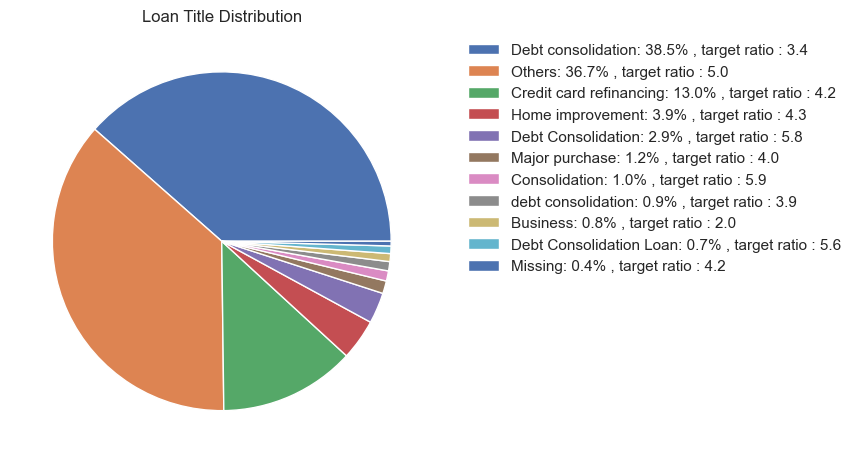

In [58]:
# Plotting top 20 categories and comnbining rest as "Others" and creating new category for "Missing"
top_titles = list(loan_title_freq.head(10).index)
loan_title['loan_title'] = loan_title['loan_title'].fillna("Missing")
top_titles.append("Missing")
top_titles.remove("Other")
loan_title['loan_title_modified'] = loan_title['loan_title'].apply(lambda x:  x  if x in top_titles else "Others")
loan_title_modified_freq= pd.DataFrame(loan_title.groupby('loan_title_modified')['loan_status'].mean())
loan_title_modified_freq['count'] = loan_title['loan_title_modified'].value_counts()

loan_title_modified_freq =  loan_title_modified_freq.sort_values(by = 'count',ascending=False)
plt.pie(loan_title_modified_freq['count'],labels= None)
labels = [(i[0] +': '+ str(round(i[2]*100/len(loan_data),1)) + '% , target ratio : ' + str(round(i[1]/(1-i[1]),1) )) for i in loan_title_modified_freq.reset_index().values]
plt.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Loan Title Distribution')
plt.show()

In [59]:
# As there are more than 40000 categories,one hot encoding would not work, to reduce the number comparing association of loan title column with target for different number of categories considered
for i in [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,100,1000,5000]:
    sig_loan_title = list(loan_title_freq.index[:i] )
    sig_loan_title_column = loan_title['loan_title'].fillna("Missing")
    sig_loan_title.append("Missing")
    if "Other" in sig_loan_title:
        sig_loan_title.remove("Other")
    sig_loan_title_column = sig_loan_title_column.apply(lambda x : x if x in sig_loan_title else 'Others')
    loan_title_encoder = LabelEncoder()
    loan_title_encoded = loan_title_encoder.fit_transform(sig_loan_title_column)
    print("Association between Loan title when top ",i,"categories are considered:",association(np.array([loan_title_encoded+1,y_train_encoded+1]).T,method='cramer'))

Association between Loan title when top  3 categories are considered: 0.27168108294719256
Association between Loan title when top  4 categories are considered: 0.27168108294719256
Association between Loan title when top  5 categories are considered: 0.2583139016257245
Association between Loan title when top  6 categories are considered: 0.278686398863331
Association between Loan title when top  7 categories are considered: 0.22458158646539628
Association between Loan title when top  8 categories are considered: 0.22501301418095412
Association between Loan title when top  9 categories are considered: 0.19040372961747073
Association between Loan title when top  10 categories are considered: 0.19052950700532134
Association between Loan title when top  11 categories are considered: 0.20070816380198145
Association between Loan title when top  12 categories are considered: 0.1782106609852723
Association between Loan title when top  13 categories are considered: 0.1636638762245179
Association

Loan Title Insights
*  Loan Title has more than 40000 categories with varying fully paid to default ratio.
*  The association between loan purpose and target is highest when considering 6 categories and rest as "Others"
*  We can replace missing values by creating new category called "Missing"
*  We can use one hot encoding for loan purpose.

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\1780872999.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earliest_credit = pd.to_datetime(loan_data['earliest_cr_line'])


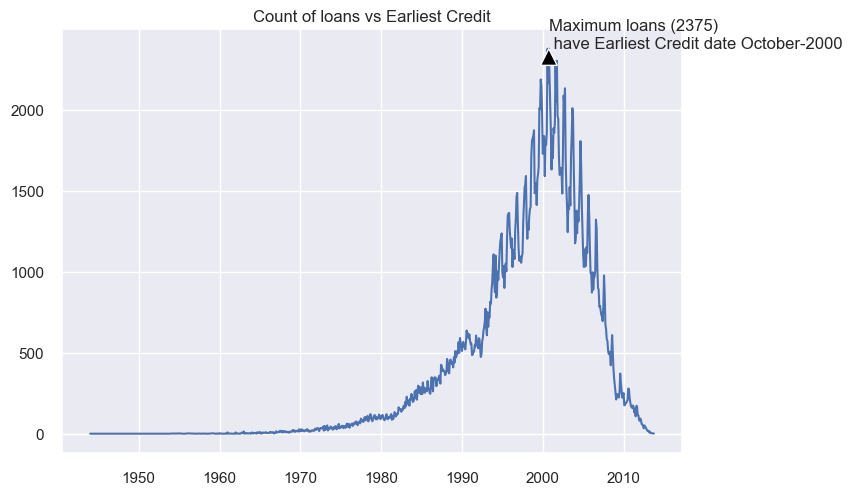

In [60]:
# Visualizing Earliest Credit line date , Plotting No of loans with earliest_cr_line
earliest_credit = pd.to_datetime(loan_data['earliest_cr_line'])
plt.plot(earliest_credit.value_counts().sort_index())
plt.title('Count of loans vs Earliest Credit')
max_value = earliest_credit.value_counts().max()
max_date = earliest_credit.value_counts().idxmax()
plt.annotate(f'Maximum loans ({max_value})\n have Earliest Credit date {max_date.month_name()}-{max_date.year}', xy=(max_date, max_value),
             xytext=(max_date, max_value + 5),
             arrowprops=dict(facecolor='black'))
plt.show()

<Axes: xlabel='earliest_cr_line'>

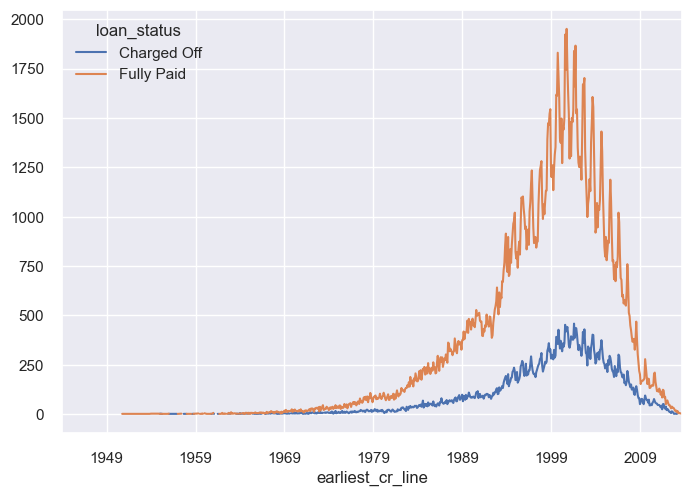

In [61]:
# Plotting loan status numbers with earliest credit
earliest_credit  = pd.DataFrame(earliest_credit)
earliest_credit['loan_status'] = y_train
freq = earliest_credit.groupby([earliest_credit['earliest_cr_line'].dt.to_period('M'),'loan_status'])['loan_status'].count()
freq.unstack().plot()

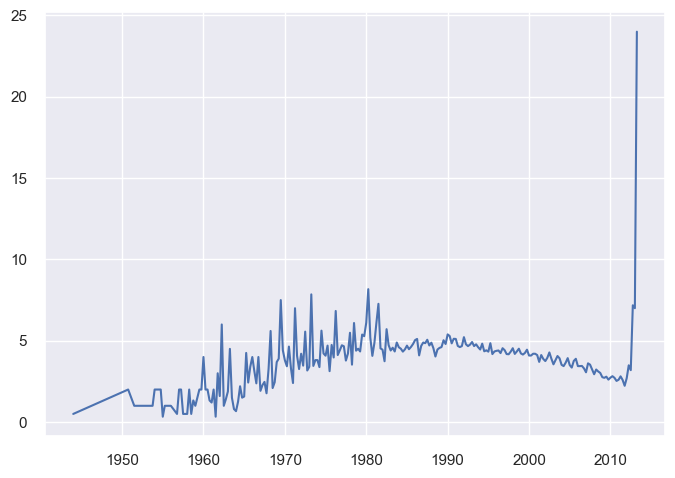

In [62]:
# Plotting Fully paid to Charged off ratio with Quarters of Earliest Credit Line date
freq_quarter = earliest_credit.groupby([earliest_credit['earliest_cr_line'].dt.to_period('Q'),'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_quarter.index.levels[0].to_timestamp()[:-2],[round(freq_quarter[i].get('Fully Paid',1)/(freq_quarter[i].get('Charged Off',0)+1 ),2) for i in freq_quarter.index.levels[0]][:-2])

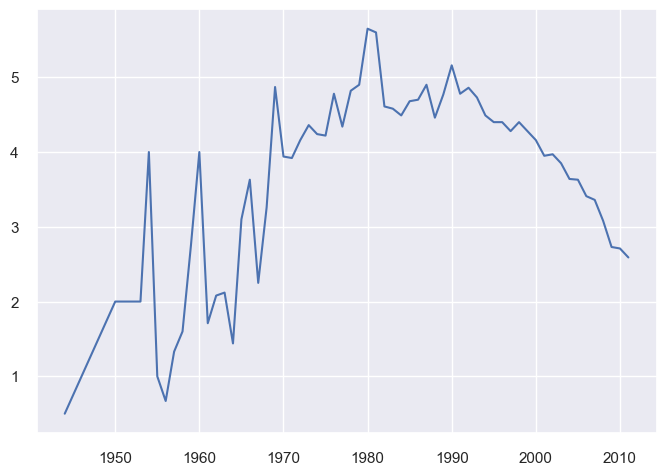

In [63]:
# Plotting Fully paid to Charged off ratio with year of Earliest Credit Line date
freq_year = earliest_credit.groupby([earliest_credit['earliest_cr_line'].dt.to_period('Y'),'loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_year.index.levels[0].to_timestamp()[:-2],[round(freq_year[i].get('Fully Paid',1)/(freq_year[i].get('Charged Off',0)+1 ),2) for i in freq_year.index.levels[0]][:-2])

In [64]:
# Earliest Credit date Year range
np.sort(pd.to_datetime(df['earliest_cr_line']).apply(lambda x: x.year).unique())

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\1776000154.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  np.sort(pd.to_datetime(df['earliest_cr_line']).apply(lambda x: x.year).unique())


array([1944, 1948, 1950, 1951, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

<Axes: xlabel='earliest_cr_line'>

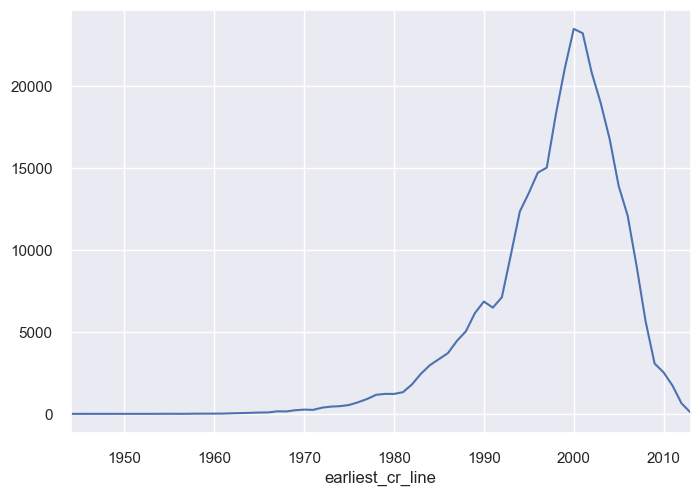

In [65]:
# Plotting number of loans with earliest cresit year
earliest_credit.groupby(earliest_credit['earliest_cr_line'].dt.to_period('Y'))['loan_status'].count().plot()

Upper bound will be : 2013
Lower bound will be : 1983


<Axes: title={'center': 'Loan count'}, xlabel='year_clipped'>

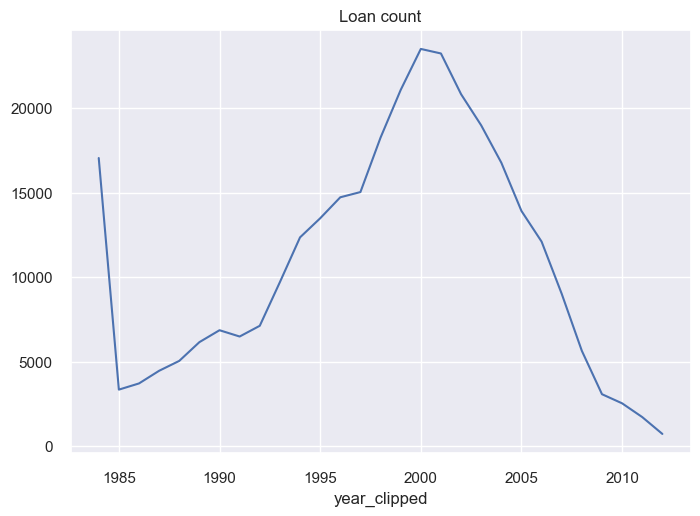

In [66]:
# No of loans is very less before 1980,So capping the years at 2nd standard deviation on both sides
yrs = earliest_credit.reset_index()['earliest_cr_line'].dt.to_period('Y').apply(lambda x: x.year)
# Capping years at the 2nd standard deviation
print("Upper bound will be :" ,yrs[stats.zscore(yrs)>2].min())
print("Lower bound will be :", yrs[stats.zscore(yrs)<-2].max())
earliest_credit['year'] = earliest_credit['earliest_cr_line'].dt.to_period('Y').apply(lambda x: x.year)
earliest_credit['year_clipped'] = earliest_credit['year'].clip((yrs[stats.zscore(yrs)<-2].max())+1,(yrs[stats.zscore(yrs)>2].min())-1)
earliest_credit['year_clipped'].value_counts().sort_index().plot(title='Loan count')

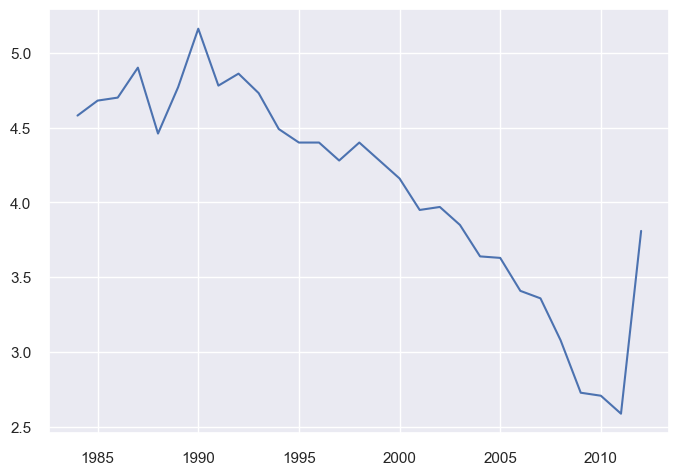

In [67]:
# Plotting Fully paid to Charged off ratio with clipped year of Earliest Credit Line date
freq_year = earliest_credit.groupby(['year_clipped','loan_status'])['loan_status'].count().rename('count')
plt.plot(freq_year.index.levels[0],[round(freq_year[i].get('Fully Paid',1)/(freq_year[i].get('Charged Off',0)+1 ),2) for i in freq_year.index.levels[0]])

In [68]:
# As there are still lot of years for aplying one hot encoded we can reduce into different number of time periods
earliest_credit['loan_status_encoded'] = y_train_encoded
li = [1,2,3,4,5,6,7,8,9,10,11,15,20,29]
def earliest_credit_grp(x,k):
    p = (2013-1984)/(k)
    return (x-1984)//p
for i in li:
    earliest_credit['year_clipped_grp'] = earliest_credit['year_clipped'].apply(lambda x: earliest_credit_grp(x,i))
    print("Mutual Information with target when earliest credit column split into ",i,"periods : ",mutual_info_classif(pd.DataFrame(earliest_credit['year_clipped_grp']),earliest_credit['loan_status'],discrete_features=True)[0])
    print(association(np.array([earliest_credit['year_clipped_grp'].apply(int).values + 1,y_train_encoded+1]).T,method='cramer'))

Mutual Information with target when earliest credit column split into  1 periods :  0.0
0.12069369774732343
Mutual Information with target when earliest credit column split into  2 periods :  0.0006887947280164175
0.20675642731404179
Mutual Information with target when earliest credit column split into  3 periods :  0.0010082391011241032
0.21070898540966687
Mutual Information with target when earliest credit column split into  4 periods :  0.0010688157443210916
0.22680146778906138
Mutual Information with target when earliest credit column split into  5 periods :  0.001122697957420836
0.2276185056540343
Mutual Information with target when earliest credit column split into  6 periods :  0.001197890674732159
0.23109951668763257
Mutual Information with target when earliest credit column split into  7 periods :  0.001213326689922252
0.2423088607219469
Mutual Information with target when earliest credit column split into  8 periods :  0.0011938345216184858
0.2401455294008239
Mutual Informati

Earliest Credit Line Insights
*  The dataset has Earliest Credit Line with years ranging from 1944 to 2013
*  The number of loans per year seems to hit maximum around 2000
*  Converting to different quarters and plotting target ratio the ratio varies between 0 to 8 till 2012 and is much higher for 2013 because of less data in 2013.
* After capping the column at 2nd standard deviaiton and splitting the dataset into periods we can find that while splitting the time period into 7 years, yields the most information (considering both mutual information and association)
*  For preprocessing we can split the column into 15  time periods and 4 quarters and apply one hot encoding

C:\Users\sanju\AppData\Local\Temp\ipykernel_7964\3218546289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_data['loan_default'] = y_train_encoded


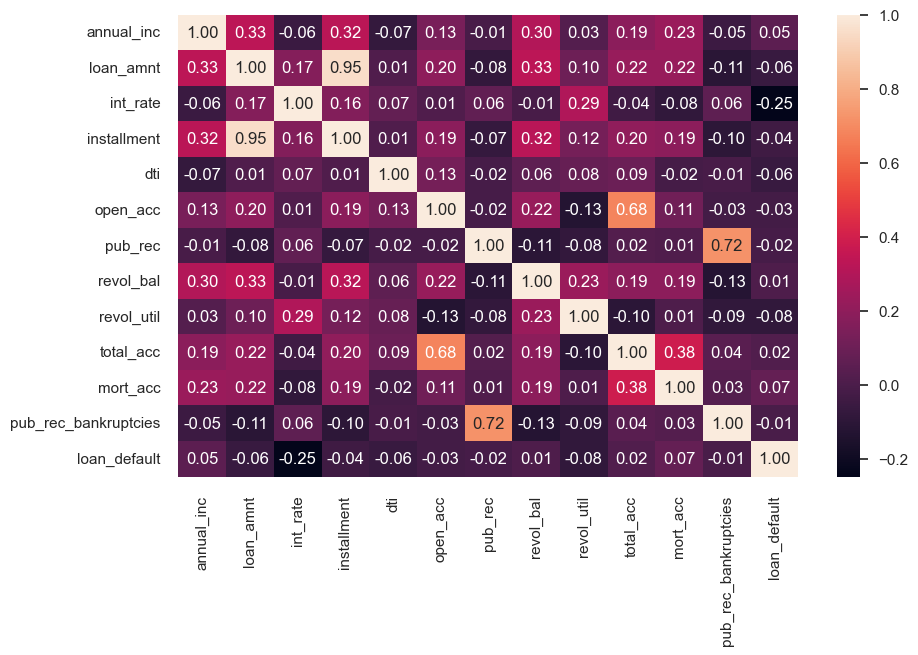

In [69]:
# Coorelation Heat map of pure numerical columns with target
num_data = loan_data[['annual_inc','loan_amnt','int_rate','installment','dti',
                      'open_acc','pub_rec','revol_bal','revol_util','total_acc','mort_acc','pub_rec_bankruptcies']]
num_data['loan_default'] = y_train_encoded
fig, ax = plt.subplots()
sns.heatmap(num_data.corr(),annot=True,fmt=".2f" ,ax = ax)
fig.set_size_inches(10,6)

In [70]:
# # Calculate summary statistics
# desc = loan_data['open_acc'].describe()

# # Calculate IQR boundaries
# Q1 = desc['25%']
# Q3 = desc['75%']
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Find outliers
# outliers = loan_data[(loan_data['open_acc']< lower_bound) | (loan_data['open_acc'] > upper_bound)]
# print(f"Number of outliers: {len(outliers)}")
# print("\nOutlier values:")
# print(outliers.iloc[:10])